# Final Project - Group 69

In [173]:
# Install packages
#install.packages(c('janitor','car','tidyr','gtsummary','glue', 'factoextra', 'patchwork'))

In [174]:
#Load necessary libraries
suppressPackageStartupMessages({
library(dplyr);
library(janitor);
library(purrr);
library(glue);
library(stringr);
library(readxl);
library(glmnet);
library(car);
library(dplyr);
library(janitor);
library(purrr);
library(glue);
library(stringr);
library(readxl);
library(IRdisplay);
library(tidyr);
library(ggplot2);
library(cluster);
library(factoextra);
library(patchwork)})

## Data Cleaning

In [175]:
# Function to preliminary clean and load data
load_and_combine_data <- function(directory_path) {
  
  file_pattern <- glue(".*-Data\\.csv$")
  
  file_paths <- list.files(path = directory_path, pattern = file_pattern, full.names = TRUE)
  
  list_of_dfs <- map(file_paths, function(path) { 
    
    year_match_result <- regmatches(path, regexpr("Y(\\d{4})\\.*", path))
    
    year_extracted <- sub("Y(\\d{4})\\.*", "\\1", year_match_result)
    
    read.csv(path, skip = 1, na.strings = c("N", "-", "(X)", "null")) %>% 
      clean_names() %>%
      mutate(year = as.numeric(year_extracted)) %>%
      mutate(state = str_trim(str_extract(geographic_area_name, ",\\s*([^,]+)$"), side = "left"),
             state = str_replace(state, "^,\\s*", "")) %>%
      select(-contains(c("margin_of_error", "ratio", "unit", "percent", "x", "geograph")))
      }
    )
  
  common_columns <- names(list_of_dfs[[1]])
  
  for (i in 2:length(list_of_dfs)) {
    common_columns <- intersect(common_columns, names(list_of_dfs[[i]]))
  }
  
  list_of_dfs_common_cols <- map(list_of_dfs, ~ .x %>% select(all_of(common_columns)))
  
  for (col_name in common_columns) {
    first_col_type <- class(list_of_dfs_common_cols[[1]][[col_name]])
    
    if (first_col_type %in% c("numeric", "integer")) {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.numeric(df[[col_name]])
        df
      })
    } else if (first_col_type == "factor") {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.character(df[[col_name]])
        df
      })
    }
  }
  
  yearly_data <- bind_rows(list_of_dfs_common_cols)
  
  yearly_data
}

load_and_combine_borrower_data <- function(filepath, sheet_numbers, years) {

  combined_borrower_data <- map2_df(sheet_numbers, years, function(sheet, year) {
    read_excel(filepath, sheet = sheet, skip = 7) %>%
    clean_names() %>%
    mutate(year = year)
  })
  
  final_borrower_data <- combined_borrower_data %>%
    select(state, year, total_borrowers, total_balance_billions)
  
  final_borrower_data
}

In [176]:
# loading datasets
dem_data <- load_and_combine_data("../data/dem") 
economic_data <- load_and_combine_data("../data/economic")
mean_income_data <- load_and_combine_data("../data/mean_income")
social_char_data <- load_and_combine_data("../data/social_char") 
borrower_data <-load_and_combine_borrower_data("../data/Student-loan-update-2025-Mangrum.xlsx", 11:15, 2019:2023)

In [177]:
# Checking what the datasets look like after initial cleaning
dem_data %>% 
    head(2)

borrower_data %>% 
    head(2)

,estimate_race_total_population,estimate_race_total_population_one_race,estimate_race_total_population_two_or_more_races,estimate_race_total_population_one_race_1,estimate_race_total_population_one_race_white,estimate_race_total_population_one_race_black_or_african_american,estimate_race_total_population_one_race_american_indian_and_alaska_native,estimate_race_total_population_one_race_asian,estimate_race_total_population_one_race_asian_asian_indian,estimate_race_total_population_one_race_asian_chinese,⋯,estimate_hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_asian_alone,estimate_hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_native_hawaiian_and_other_pacific_islander_alone,estimate_hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_some_other_race_alone,estimate_hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races,estimate_hispanic_or_latino_and_race_total_population_not_hispanic_or_latino_two_or_more_races_two_races_including_some_other_race,estimate_citizen_voting_age_population_citizen_18_and_over_population,estimate_citizen_voting_age_population_citizen_18_and_over_population_male,estimate_citizen_voting_age_population_citizen_18_and_over_population_female,year,state
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,55380,54182,1198,54182,42527,10538,140,573,0,87,⋯,573,5,85,1173,0,41647,19823,21824,2019,Alabama
2,212830,209241,3589,209241,183471,19718,1645,1969,505,619,⋯,1955,9,344,3092,82,162883,77958,84925,2019,Alabama


state,year,total_borrowers,total_balance_billions
<chr>,<int>,<dbl>,<dbl>
Alabama,2019,606800,21.57
Alaska,2019,74060,2.40


Since we have the count for each variable in the dataset, we will standardize it by dividing the variable by it's total for all variables, that will make all states representa a percentage of the population instead of a count and would be a fair way to compare between states.

In [178]:
# Clean and combine the data
dem_data_cleaned <- dem_data %>%
  rename(total_population = estimate_race_total_population,
         race_white = estimate_race_total_population_one_race_white,
         race_black = estimate_race_total_population_one_race_black_or_african_american,
         race_asian = estimate_race_total_population_one_race_asian,
         race_native = estimate_race_total_population_one_race_american_indian_and_alaska_native,
         race_pacific_islander = estimate_race_total_population_one_race_native_hawaiian_and_other_pacific_islander,
         race_other = estimate_race_total_population_one_race_some_other_race,
         race_two_or_more = estimate_race_total_population_two_or_more_races,
         hispanic_or_latino = estimate_hispanic_or_latino_and_race_total_population_hispanic_or_latino_of_any_race,
         total_18_or_over_population = estimate_citizen_voting_age_population_citizen_18_and_over_population,
         population_18_or_over_male = estimate_citizen_voting_age_population_citizen_18_and_over_population_male,
         population_18_or_over_female = estimate_citizen_voting_age_population_citizen_18_and_over_population_female) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE)), .groups = "drop") %>%
  ungroup() %>%
  mutate(across(race_two_or_more:hispanic_or_latino, ~./total_population),
         across(population_18_or_over_male:population_18_or_over_female, ~./total_18_or_over_population))

economic_data_cleaned <- economic_data %>%
  rename(employment_total = estimate_employment_status_population_16_years_and_over,
         employment_total_employed = estimate_employment_status_population_16_years_and_over_in_labor_force,
         employment_total_unemployed = estimate_employment_status_population_16_years_and_over_not_in_labor_force) %>%
  select(-contains("estimate"))  %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE)), .groups = "drop") %>%
  ungroup() %>%
  mutate(across(employment_total_employed:employment_total_unemployed, ~./employment_total)) %>%
  select(-employment_total)

mean_income_data_cleaned <- mean_income_data %>%
  group_by(state, year) %>%
  summarise(mean_household_income_dollars = mean(estimate_mean_income_dollars_household_income_all_households, na.rm=TRUE), .groups = "drop") %>%
  ungroup()

social_char_data_cleaned <- social_char_data %>%
  rename(average_household_size = estimate_households_by_type_total_households_average_household_size,
         total_veteran_eligible = estimate_veteran_status_civilian_population_18_years_and_over,
         total_veteran = estimate_veteran_status_civilian_population_18_years_and_over_civilian_veterans,
         total_population_degree = estimate_educational_attainment_population_25_years_and_over,
         total_population_bachelors_degree = estimate_educational_attainment_population_25_years_and_over_bachelor_s_degree_or_higher,
         total_foreign_born_pop = estimate_u_s_citizenship_status_foreign_born_population,
         total_households = estimate_households_by_type_total_households,
         total_household_w_internet = estimate_computers_and_internet_use_total_households_with_a_broadband_internet_subscription) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(-average_household_size, ~sum(., na.rm=TRUE)), 
            average_household_size = mean(average_household_size, na.rm=TRUE), .groups = "drop") %>%
  ungroup() %>%
  mutate(total_veteran = total_veteran/total_veteran_eligible, 
         total_population_bachelors_degree = total_population_bachelors_degree/total_population_degree,
         total_household_w_internet = total_household_w_internet/total_households) %>%
  select(-c(total_veteran_eligible, total_population_degree, total_households))


combined_data <- dem_data_cleaned %>%
  left_join(economic_data_cleaned, by = c("state", "year")) %>%
  left_join(mean_income_data_cleaned, by = c("state", "year")) %>%
  left_join(social_char_data_cleaned, by = c("state", "year")) %>%
  left_join(borrower_data, by = c("state", "year")) %>%
  relocate(state, year) %>%
  filter(!state == "Puerto Rico", !state == "District of Columbia") %>%
  mutate(total_foreign_born_pop = total_foreign_born_pop/total_population,
         total_borrowers = total_borrowers/total_18_or_over_population) %>%
  select(-c(total_population, total_18_or_over_population))

In [179]:
# checking the first few rows of the combined dataset
combined_data %>%
    head(5)

state,year,race_two_or_more,race_white,race_black,race_native,race_asian,race_pacific_islander,race_other,hispanic_or_latino,⋯,employment_total_employed,employment_total_unemployed,mean_household_income_dollars,total_population_bachelors_degree,total_veteran,total_foreign_born_pop,total_household_w_internet,average_household_size,total_borrowers,total_balance_billions
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,2019,0.01891207,0.6809017,0.2664031,0.005242758,0.01359036,0.0004589592,0.01449105,0.04278411,⋯,0.5740216,0.4259784,59561.31,0.2546833,0.08766780,0.03546721,0.7639913,2.569403,0.1646643,21.57
Alabama,2020,0.02438534,0.6749864,0.2659451,0.005060915,0.01387828,0.0004173150,0.01532662,0.04351991,⋯,0.5755210,0.4244790,61632.36,0.2622735,0.08581328,0.03434429,0.7991543,2.545970,0.1621598,22.29
Alabama,2021,0.03107745,0.6680286,0.2649698,0.004334215,0.01403873,0.0003405584,0.01721060,0.04495270,⋯,0.5776099,0.4223901,65245.01,0.2666894,0.08416339,0.03470194,0.8204571,2.627761,0.1625385,23.07
Alabama,2022,0.03691897,0.6620826,0.2637861,0.004200798,0.01388360,0.0004480825,0.01867985,0.04622171,⋯,0.5795181,0.4204819,70621.25,0.2720839,0.08110404,0.03524339,0.8378641,2.570597,0.1634605,23.38
Alabama,2023,0.04512042,0.6535822,0.2608708,0.004449916,0.01423930,0.0005072955,0.02123004,0.05374484,⋯,0.5814381,0.4185619,73195.54,0.2775514,0.07932469,0.03799553,0.8561986,2.517463,0.1643160,23.57


In [180]:
# saving the dataset so we do not have to run cleaning everytime
write.csv(combined_data, "../data/combined_clean_data.csv", row.names = FALSE)

In [181]:
# loading the saved data
student_debt_data <- read.csv("../data/combined_clean_data.csv")

## Exploratory Data Analysis

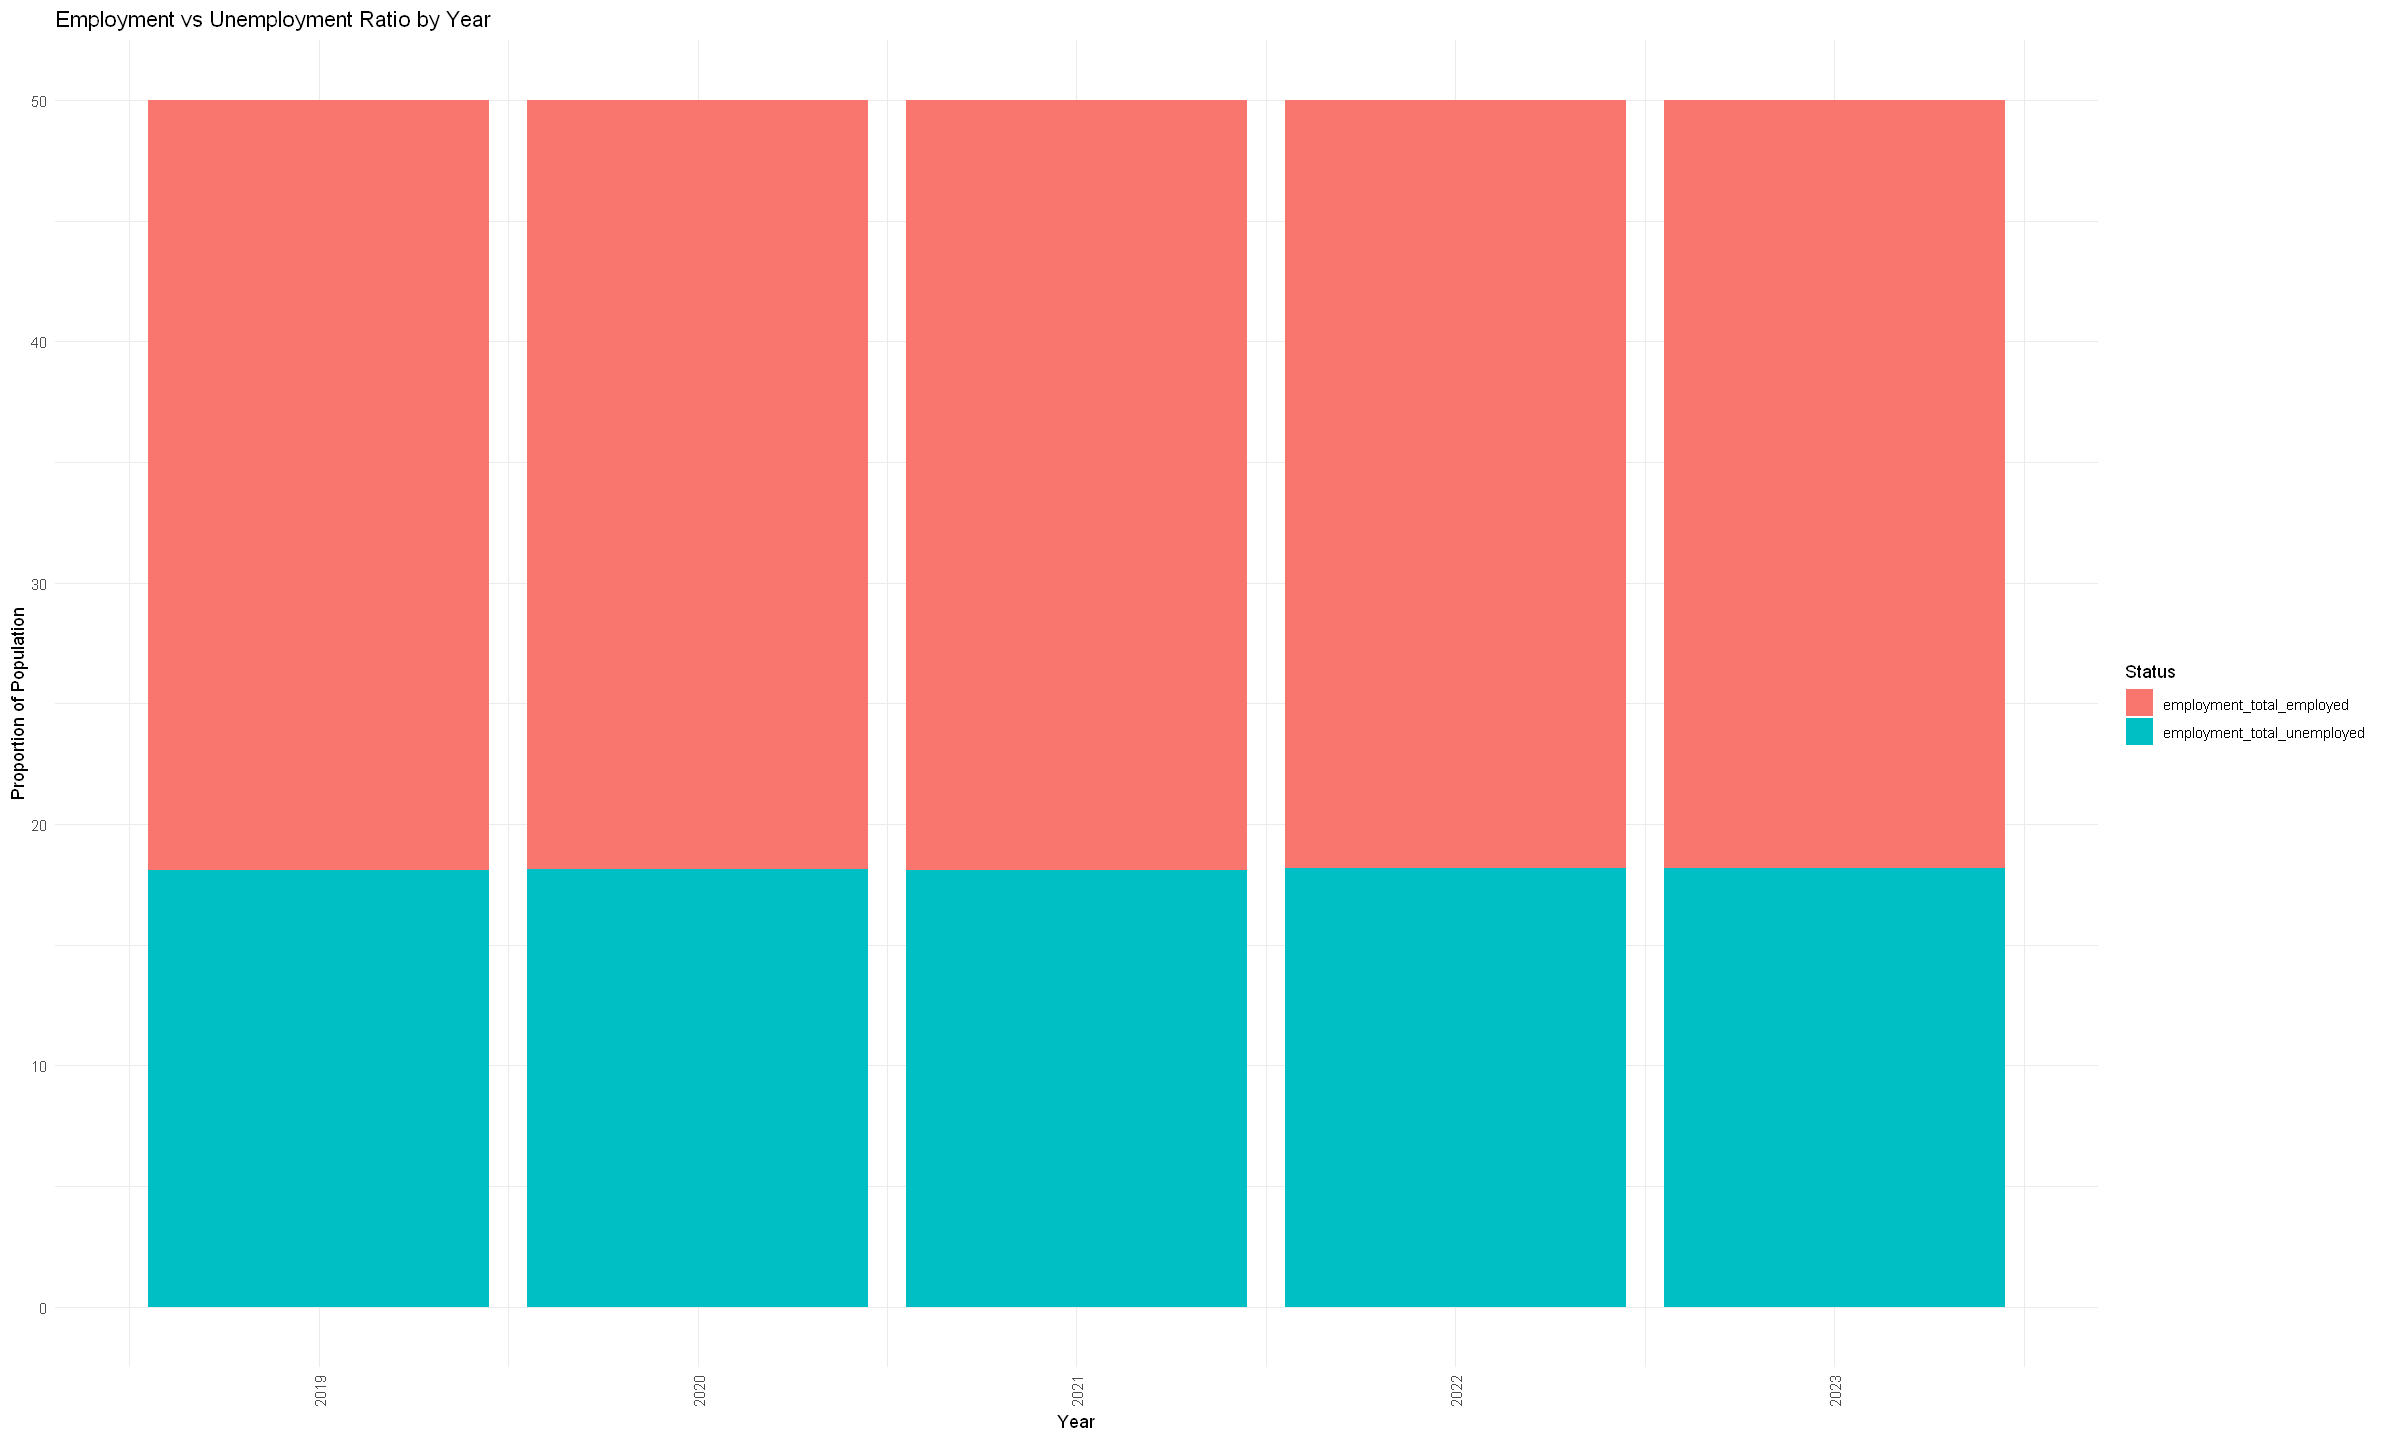

In [182]:
# Employment status of US population over the course of 5 years (2019 to 2023)
options(repr.plot.width = 20, repr.plot.height = 12) 

employment_plot_data <- student_debt_data %>%
  select(year, employment_total_employed, employment_total_unemployed) %>%
  pivot_longer(cols = c(employment_total_employed, employment_total_unemployed),
               names_to = "status",
               values_to = "proportion")

# Plot
ggplot(employment_plot_data, aes(x = year, y = proportion, fill = status)) +
  geom_bar(stat = "identity") +
  labs(title = "Employment vs Unemployment Ratio by Year",
       x = "Year",
       y = "Proportion of Population",
       fill = "Status") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

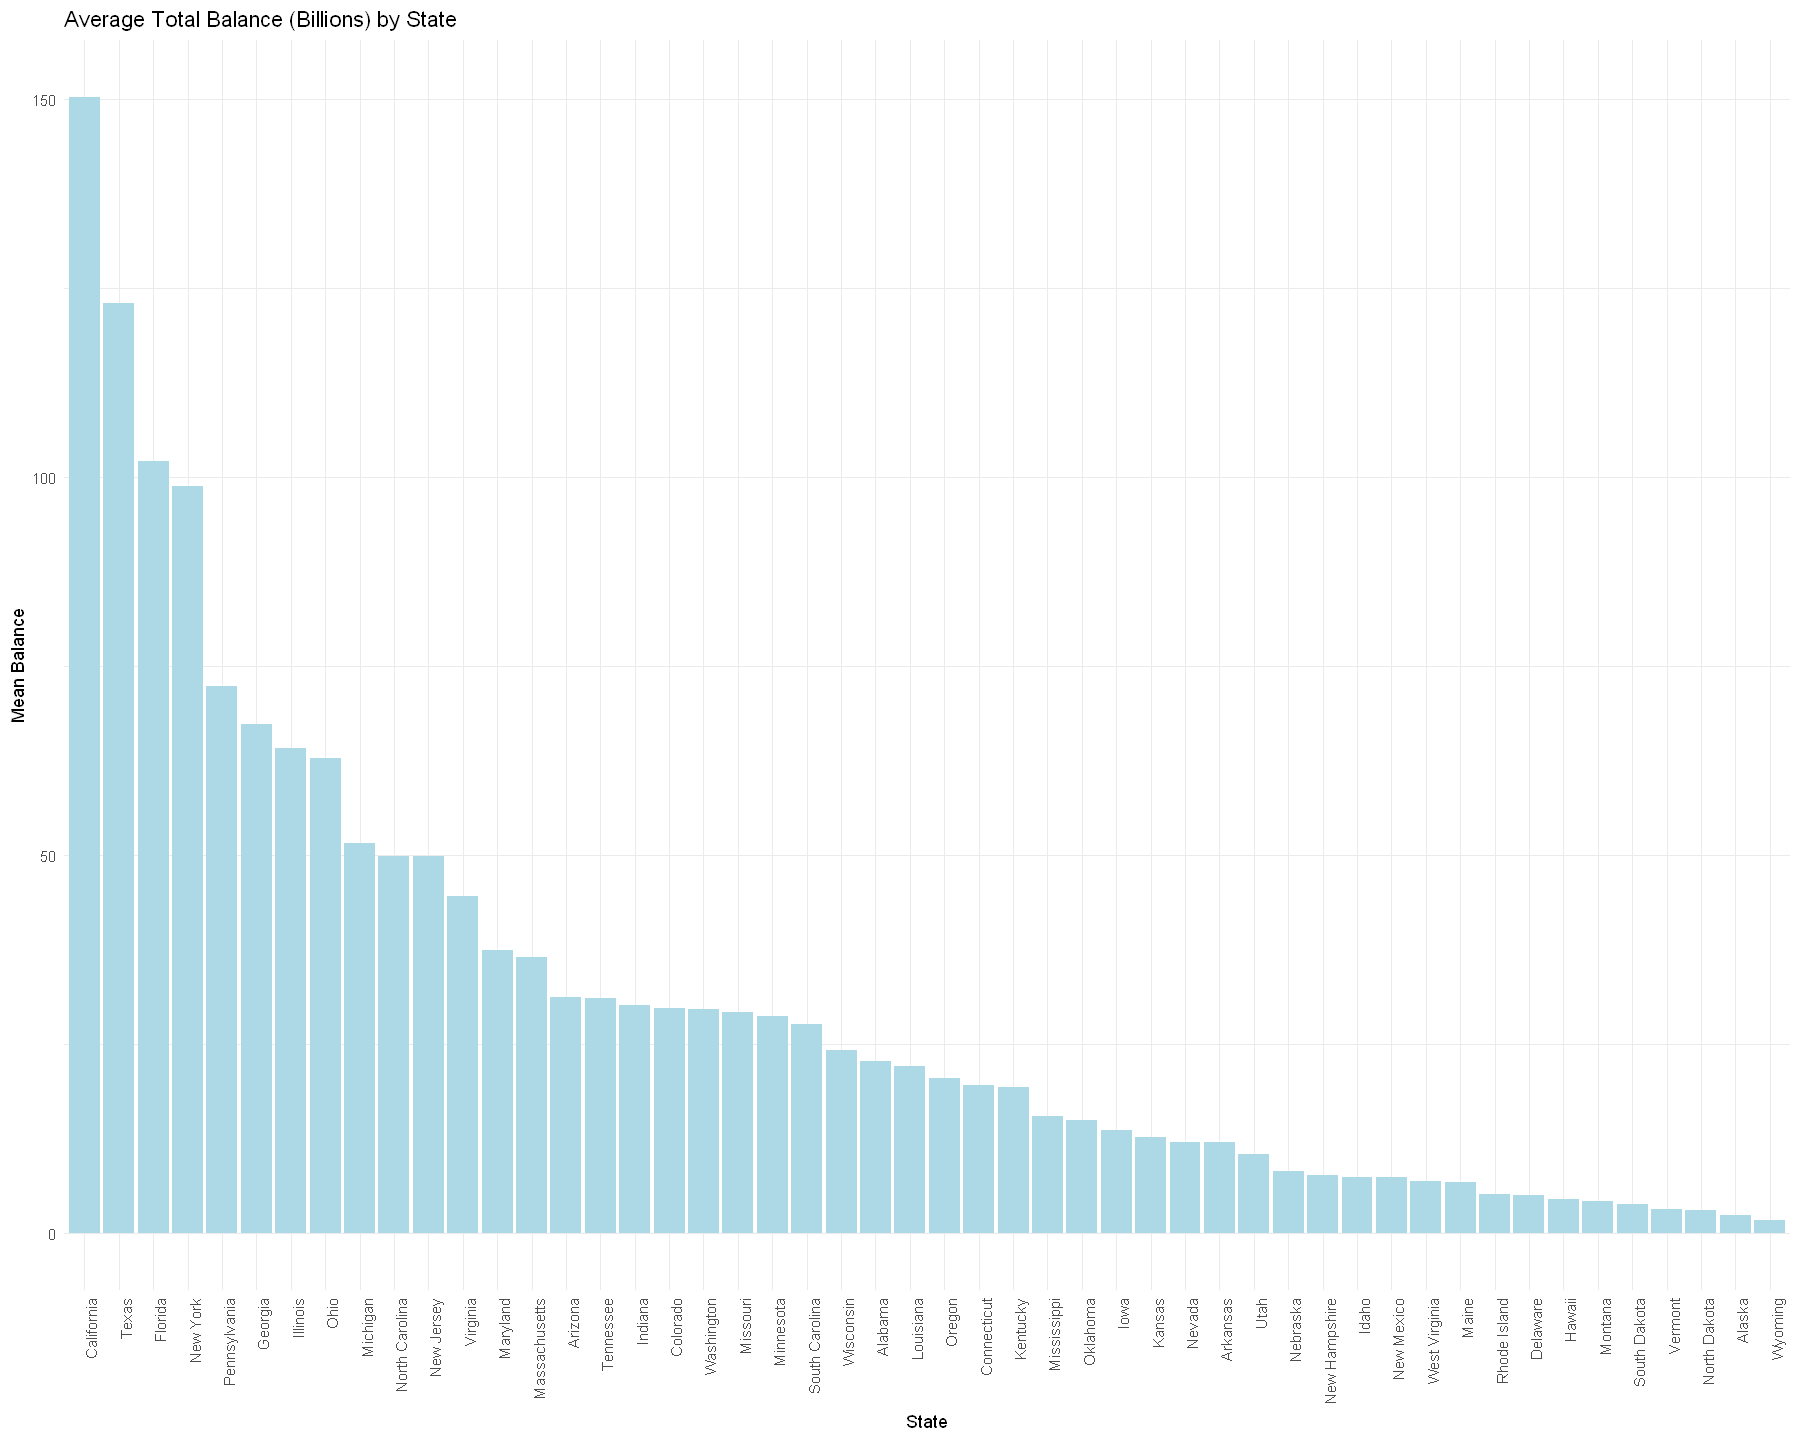

In [183]:
# Average debt across states over 2019 to 2023
options(repr.plot.width = 15, repr.plot.height = 12) 
student_debt_data %>%
  group_by(state) %>%
  summarise(mean_debt = mean(total_balance_billions, na.rm = TRUE)) %>%
  ggplot(aes(x = reorder(state, -mean_debt), y = mean_debt)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  labs(title = "Average Total Balance (Billions) by State",
       x = "State", y = "Mean Balance") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

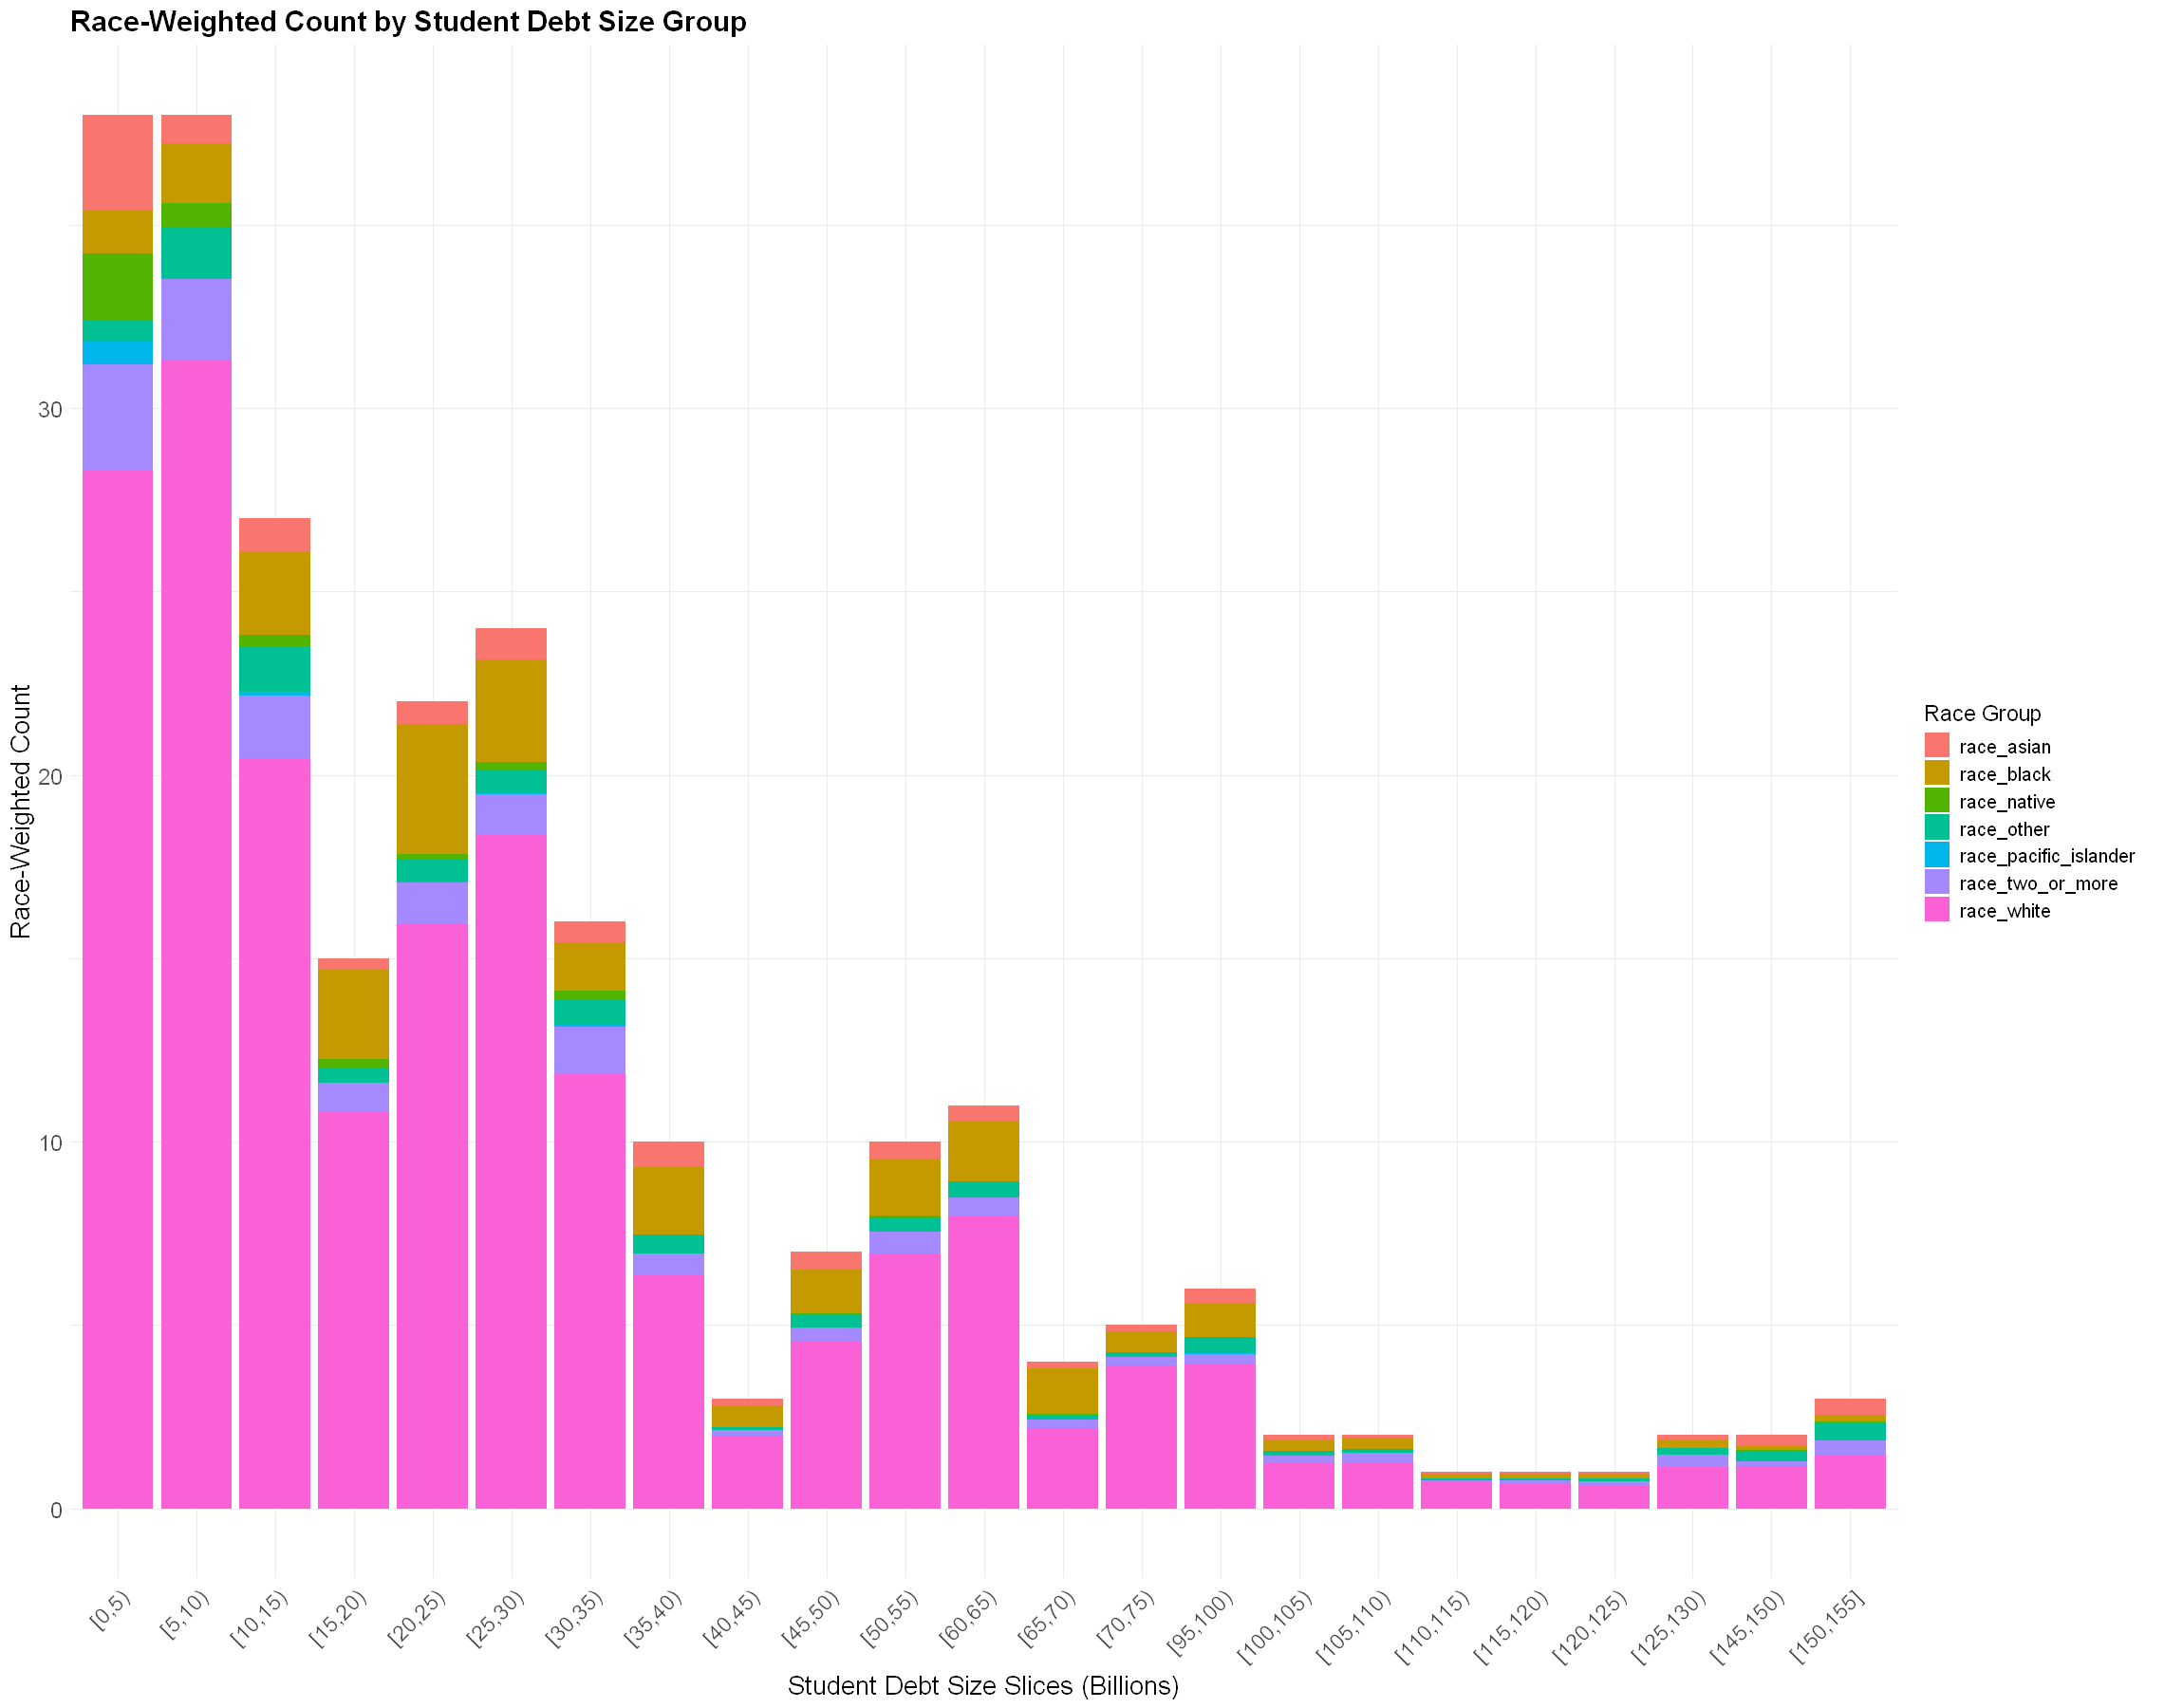

In [184]:
# Race weighted count by student debt size
options(repr.plot.width = 19, repr.plot.height = 15) 

slice_data <- student_debt_data %>%
  mutate(debt_slice = cut(total_balance_billions,
                        breaks = seq(0, ceiling(max(total_balance_billions, na.rm = TRUE)/5)*5, by = 5),
                        include.lowest = TRUE,
                        right = FALSE))

race_counts_long <- slice_data %>%
  select(debt_slice, starts_with("race_")) %>%
  pivot_longer(cols = starts_with("race_"), names_to = "race_group", values_to = "race_weight") %>%
  group_by(debt_slice, race_group) %>%
  summarise(count = sum(race_weight, na.rm = TRUE), .groups = "drop")

ggplot(race_counts_long, aes(x = debt_slice, y = count, fill = race_group)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Race-Weighted Count by Student Debt Size Group",
    x = "Student Debt Size Slices (Billions)",
    y = "Race-Weighted Count",
    fill = "Race Group"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14),  
    axis.title.x = element_text(size = 16),                        
    axis.text.y = element_text(size = 14),                         
    axis.title.y = element_text(size = 16),    
    plot.title = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )

## Models

Since our goal is to cluster by states and do MLR, we will be doing clustering first and add the clusters to the dataset as a column. We change the race data to be `minority_share`, which is all the races except `race_white` (since it's too large of a proportion to reduce multicollinearity. We also get rid of `population_18_or_over_female` and `employment_total_unemployed`, since we already have data for `population_18_or_over_male` and `employment_total_unemployed`. Before we implement k-means clustering, we take the mean of all the features across states and excluding the variables `year` (since we want state characteristics across years), `total_balance_billions` (since this is the response variable), and `total_borrowers` (since it would be highly correlated with states). We determined the optimal K by using the elbow method and we chose 3 clusters based on the curve below.

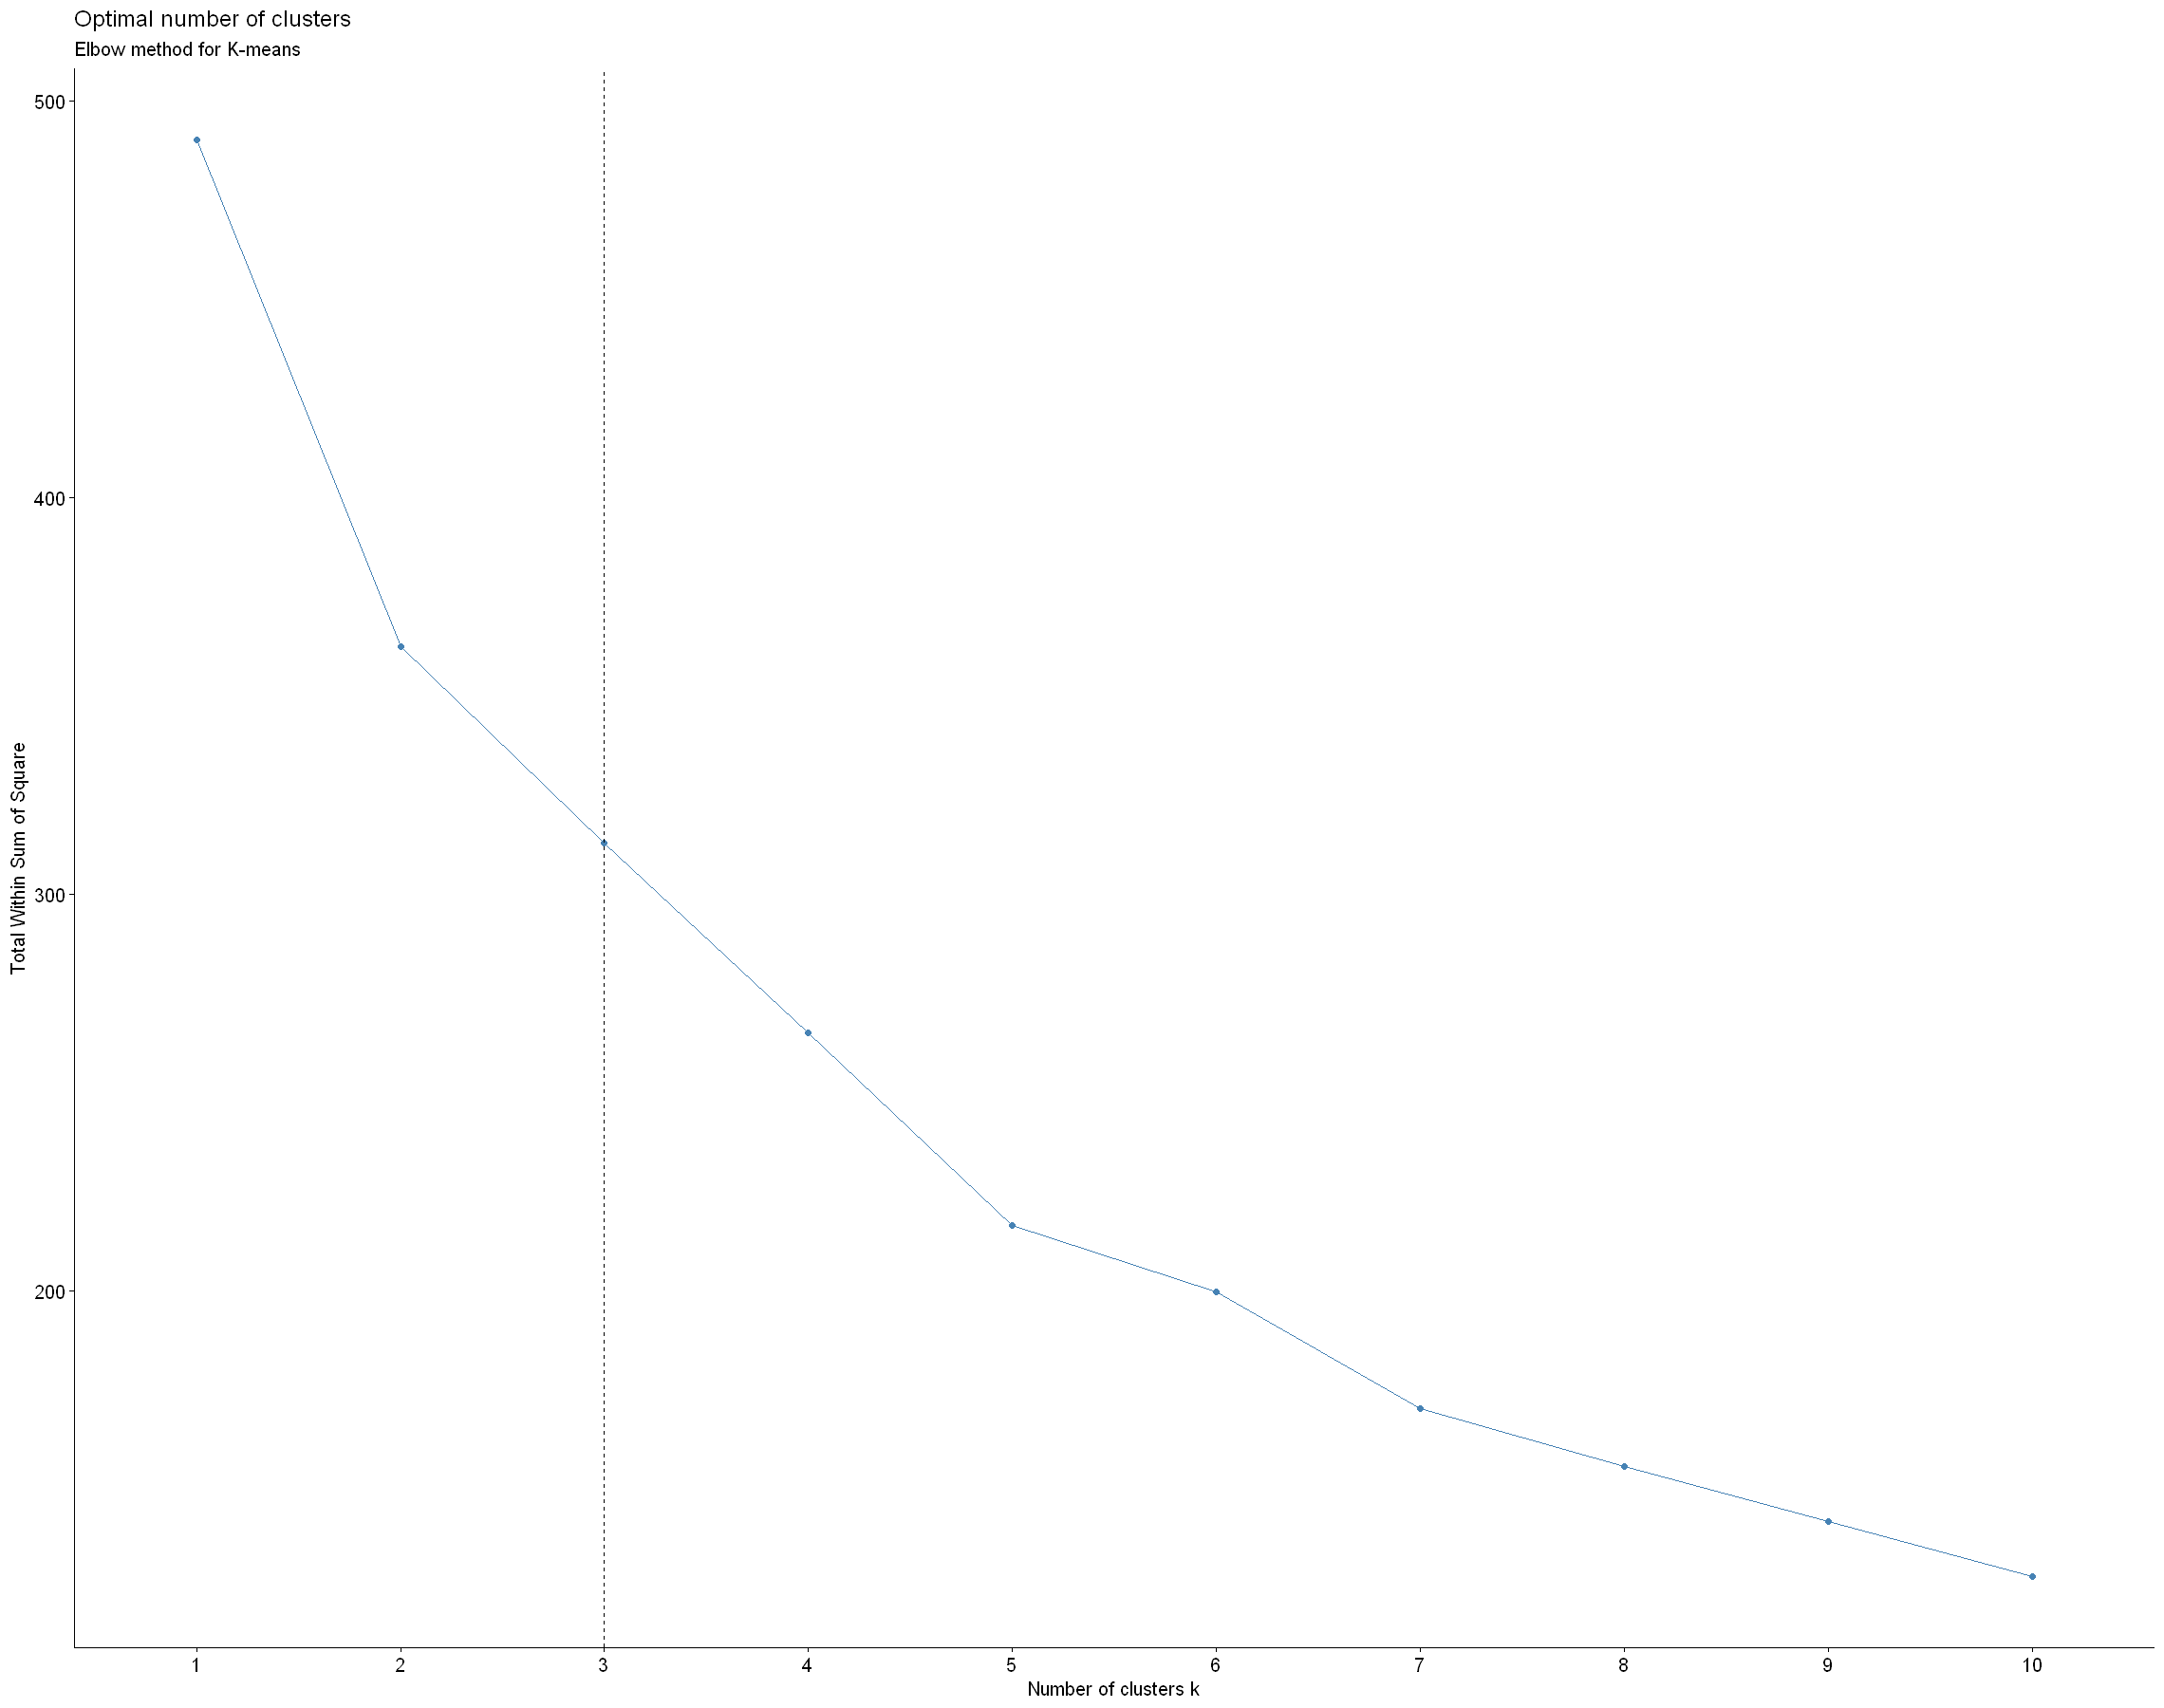

In [185]:
new_student_debt_data <- student_debt_data %>%
    mutate(minority_share = 1 - race_white) %>%
    select(-starts_with("race_"), -population_18_or_over_female, -employment_total_unemployed)

state_features_for_clustering <- new_student_debt_data %>%
    group_by(state) %>%
    summarise(across(-c(year, total_balance_billions, total_borrowers), \(x) mean(x, na.rm = TRUE)),.groups = "drop")

state_names_for_clustering <- state_features_for_clustering$state
numeric_state_features <- state_features_for_clustering %>% 
    select(-state)
scaled_state_features <- scale(numeric_state_features)

fviz_nbclust(scaled_state_features, kmeans, method = "wss", k.max = 10) +
  geom_vline(xintercept = 3, linetype = 2) +
  labs(subtitle = "Elbow method for K-means")

In [186]:
set.seed(123)
kmeans_result <- kmeans(scaled_state_features, centers = 3, nstart = 25)

state_cluster_map <- data.frame(
  state = state_names_for_clustering,
  state_cluster = as.factor(kmeans_result$cluster)
)

student_debt_with_clusters <- new_student_debt_data %>%
  left_join(state_cluster_map, by = "state")

head(student_debt_with_clusters)

,state,year,hispanic_or_latino,population_18_or_over_male,employment_total_employed,mean_household_income_dollars,total_population_bachelors_degree,total_veteran,total_foreign_born_pop,total_household_w_internet,average_household_size,total_borrowers,total_balance_billions,minority_share,state_cluster
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Alabama,2019,0.04278411,0.4748466,0.5740216,59561.31,0.2546833,0.08766780,0.03546721,0.7639913,2.569403,0.1646643,21.57,0.3190983,3
2,Alabama,2020,0.04351991,0.4746262,0.5755210,61632.36,0.2622735,0.08581328,0.03434429,0.7991543,2.545970,0.1621598,22.29,0.3250136,3
3,Alabama,2021,0.04495270,0.4776198,0.5776099,65245.01,0.2666894,0.08416339,0.03470194,0.8204571,2.627761,0.1625385,23.07,0.3319714,3
4,Alabama,2022,0.04622171,0.4780667,0.5795181,70621.25,0.2720839,0.08110404,0.03524339,0.8378641,2.570597,0.1634605,23.38,0.3379174,3
5,Alabama,2023,0.05374484,0.4764732,0.5814381,73195.54,0.2775514,0.07932469,0.03799553,0.8561986,2.517463,0.1643160,23.57,0.3464178,3
6,Alaska,2019,0.07037343,0.5280605,0.6862883,82843.90,0.2955121,0.12186167,0.07823837,0.8553875,2.920000,0.1394737,2.40,0.3541776,1


In [187]:
set.seed(123)
train_idx <- sample(seq_len(nrow(student_debt_with_clusters)), size = floor(0.8 * nrow(borrower_data)))
train_data <- student_debt_with_clusters[train_idx, ]
test_data <- student_debt_with_clusters[-train_idx, ]
# Prepare train data
train_data <- train_data %>%
  select(-state, -year)

### Full MLR Model without State Cluster

In [188]:
set.seed(123)
mlr_model <- lm(total_balance_billions ~ . -state_cluster, data = train_data)
summary(mlr_model)


Call:
lm(formula = total_balance_billions ~ . - state_cluster, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-53.569 -13.607  -1.184  10.648  69.146 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -1.477e+02  1.092e+02  -1.352 0.177735    
hispanic_or_latino                 3.823e+00  2.036e+01   0.188 0.851224    
population_18_or_over_male         1.750e+02  2.607e+02   0.671 0.502828    
employment_total_employed         -1.713e+02  7.755e+01  -2.208 0.028319 *  
mean_household_income_dollars     -1.253e-03  1.760e-04  -7.117 1.75e-11 ***
total_population_bachelors_degree  2.458e+01  5.544e+01   0.443 0.658001    
total_veteran                     -5.715e+02  1.258e+02  -4.542 9.44e-06 ***
total_foreign_born_pop             3.908e+02  4.760e+01   8.209 2.32e-14 ***
total_household_w_internet         2.299e+02  5.929e+01   3.878 0.000141 ***
average_household_size             1.4

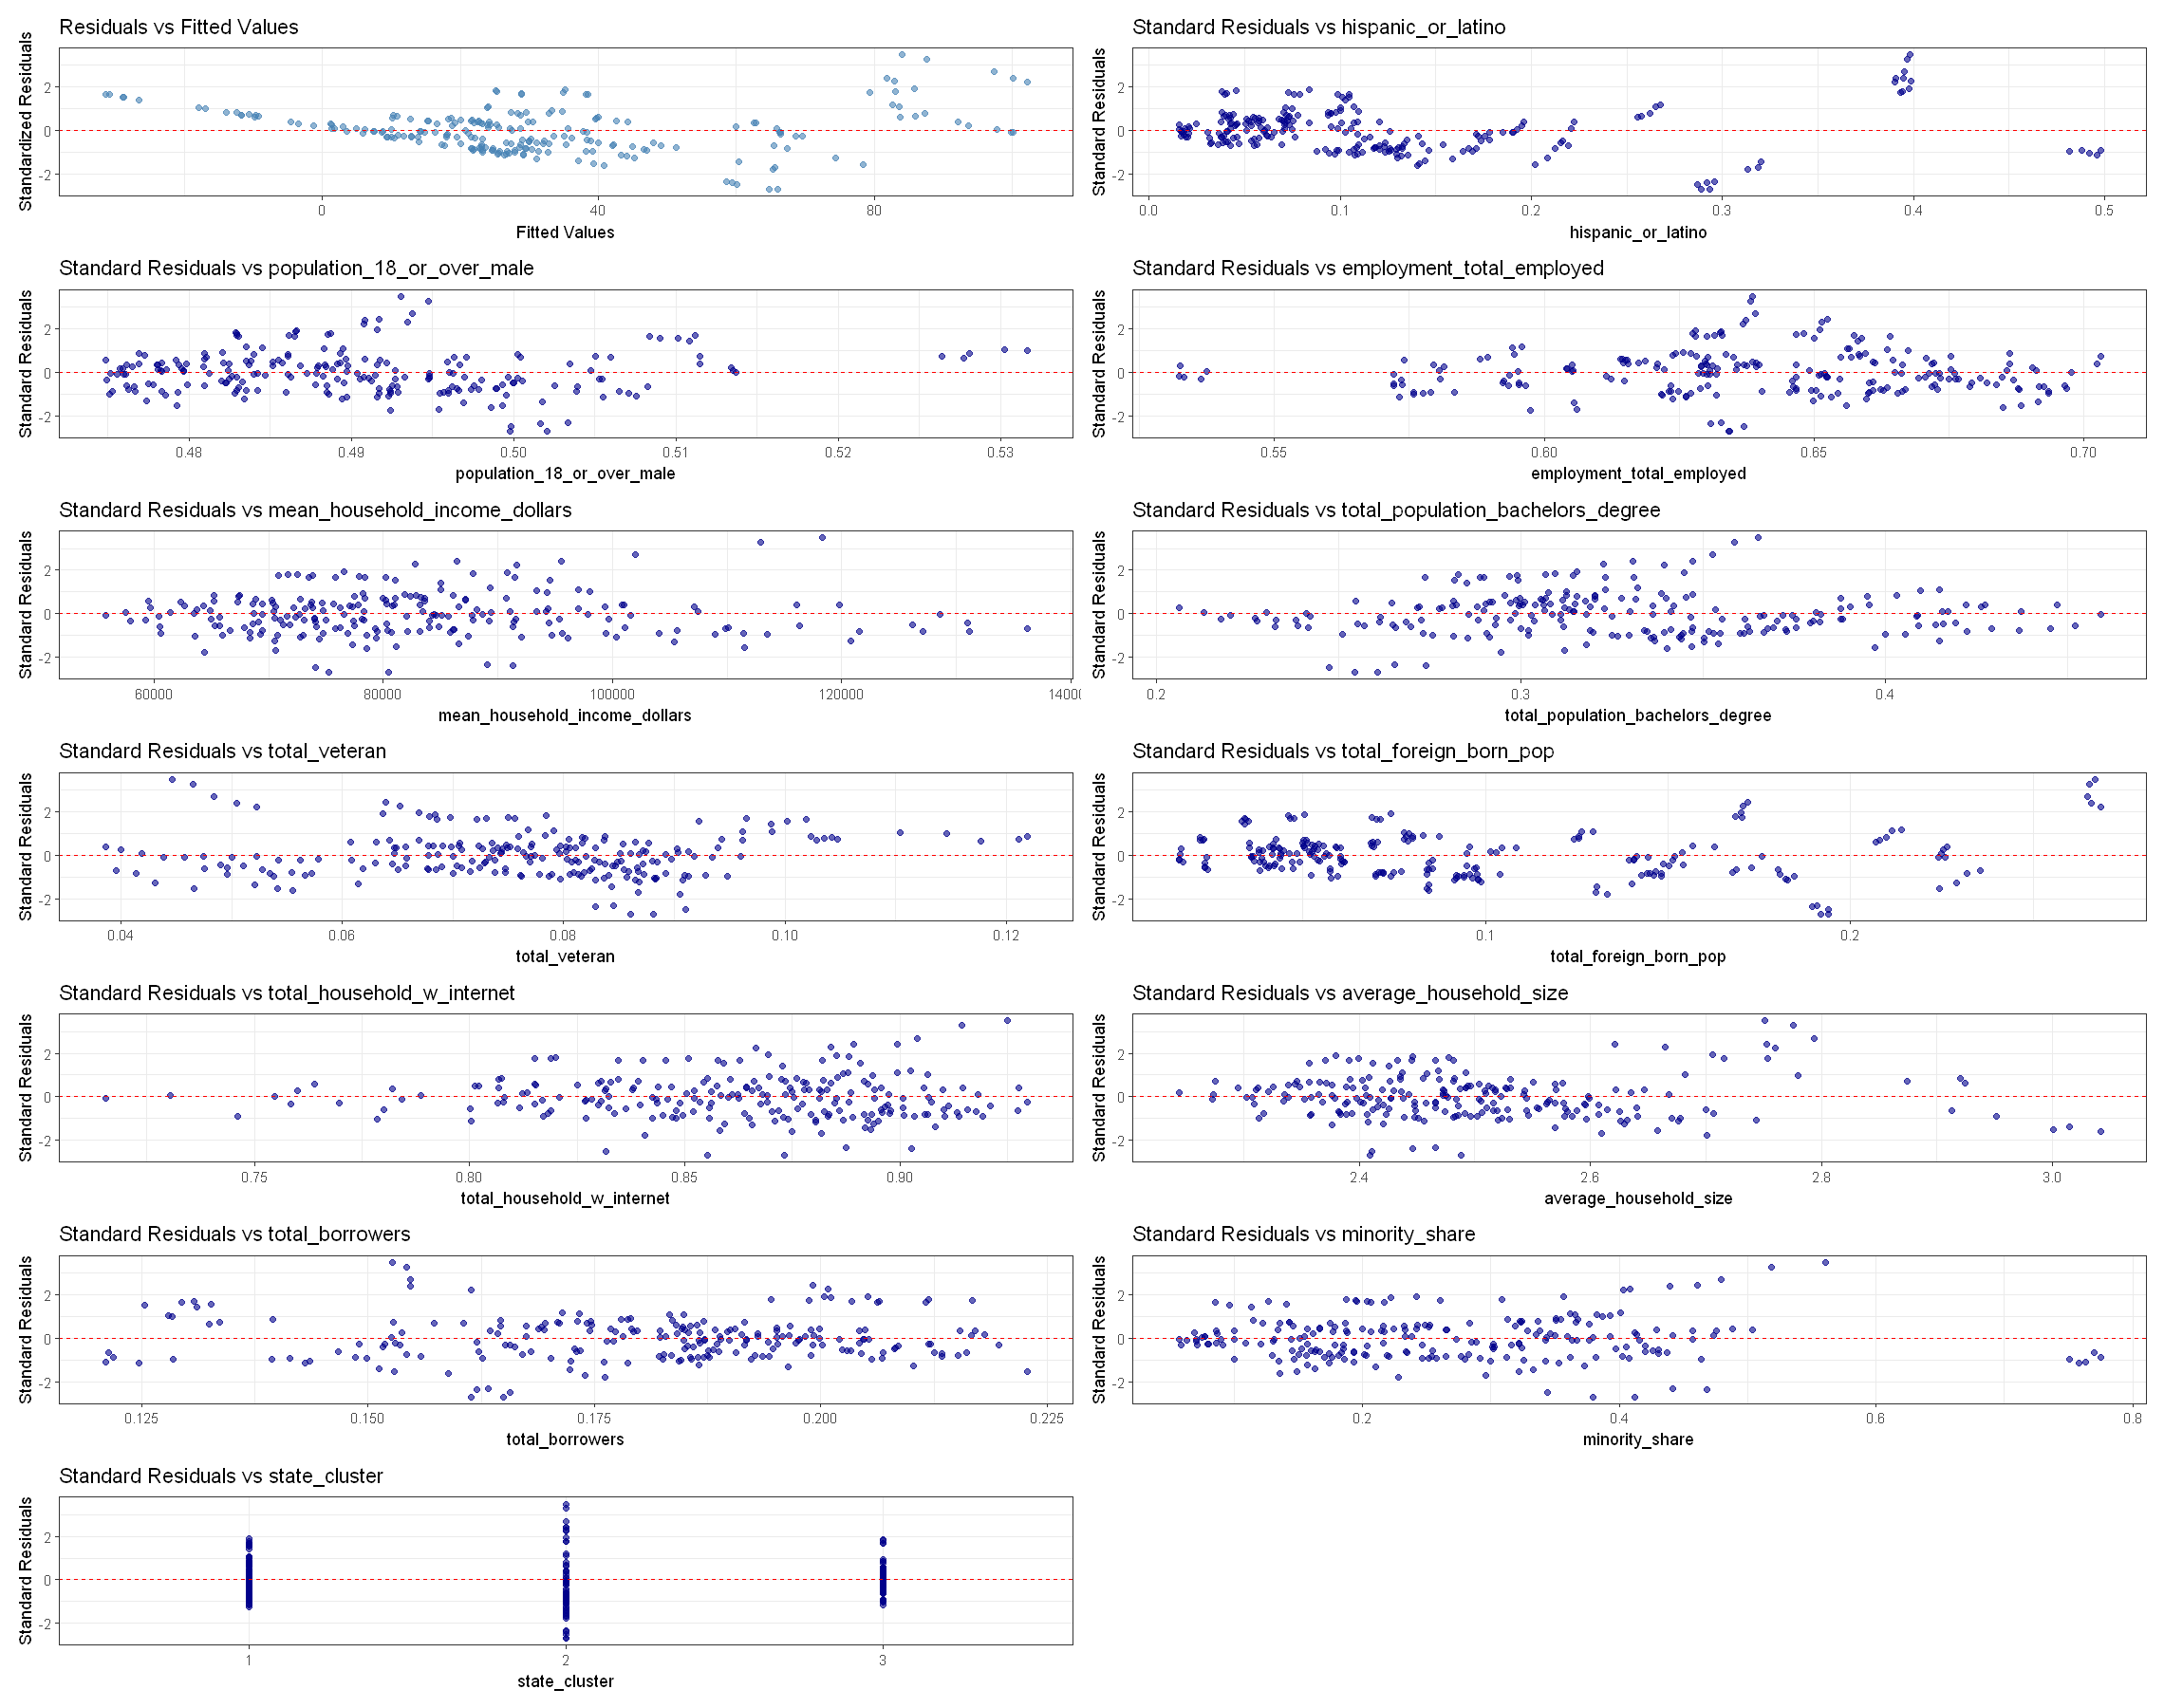

`geom_smooth()` using formula = 'y ~ x'


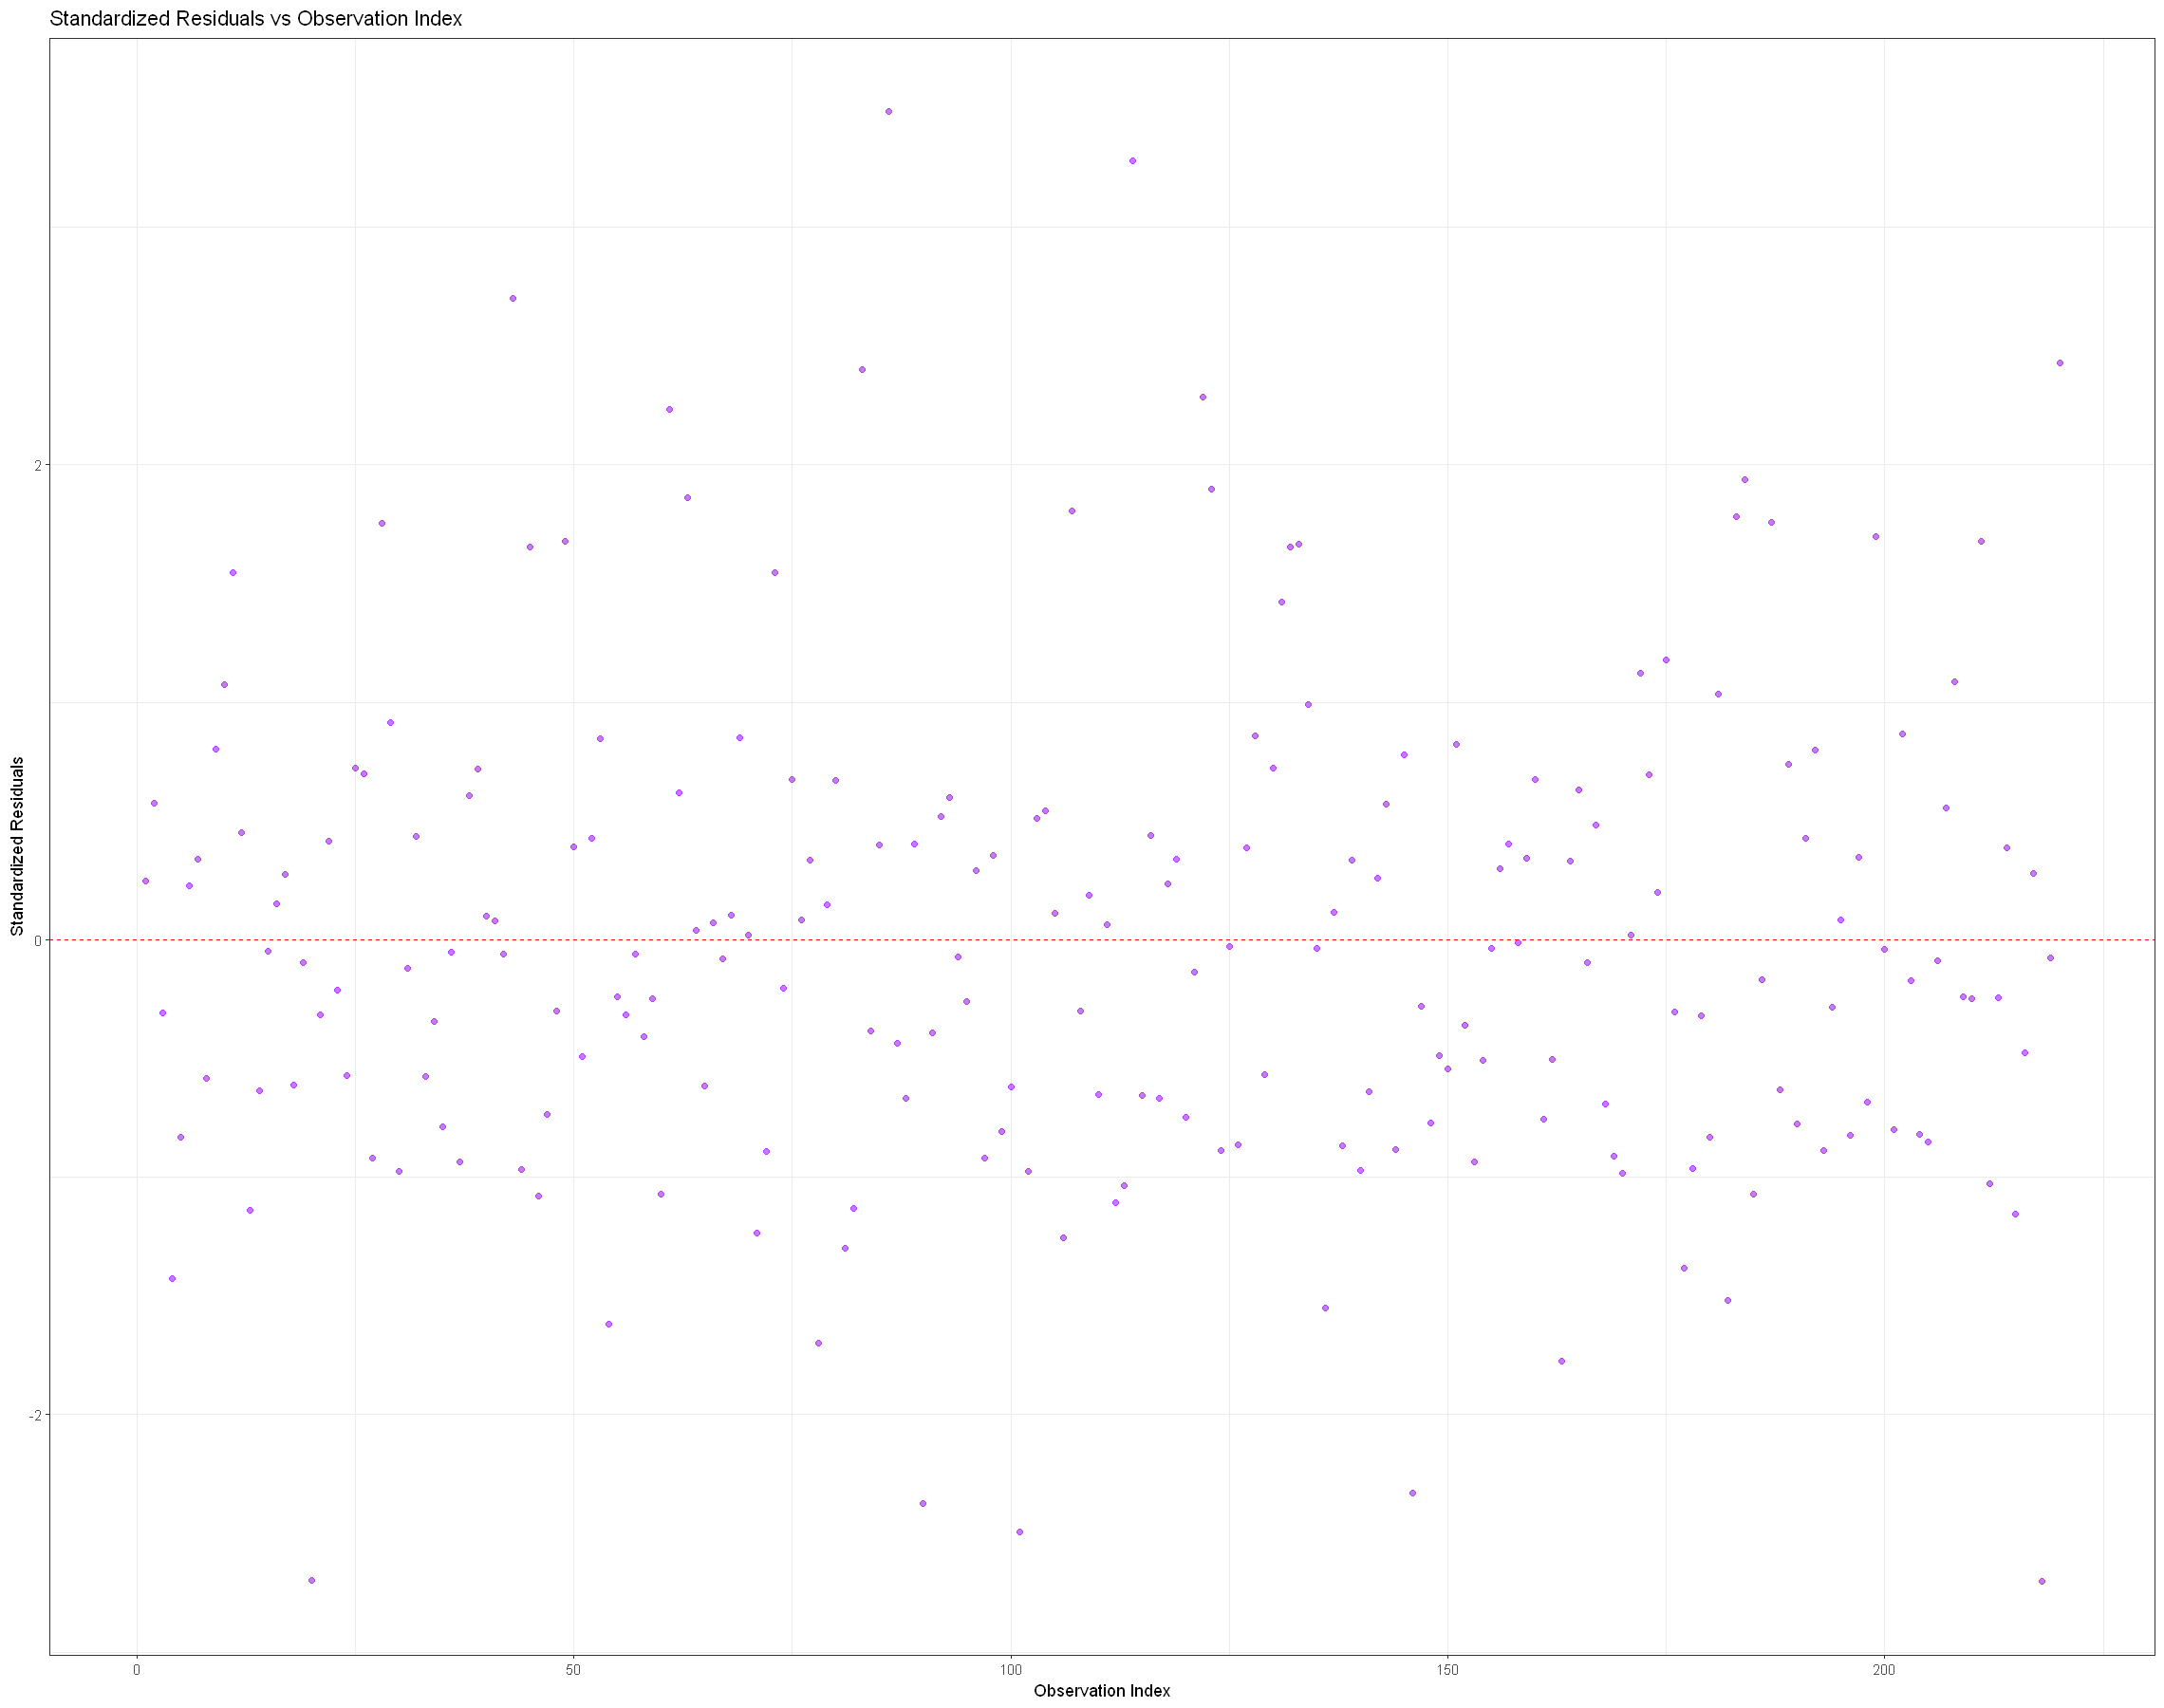

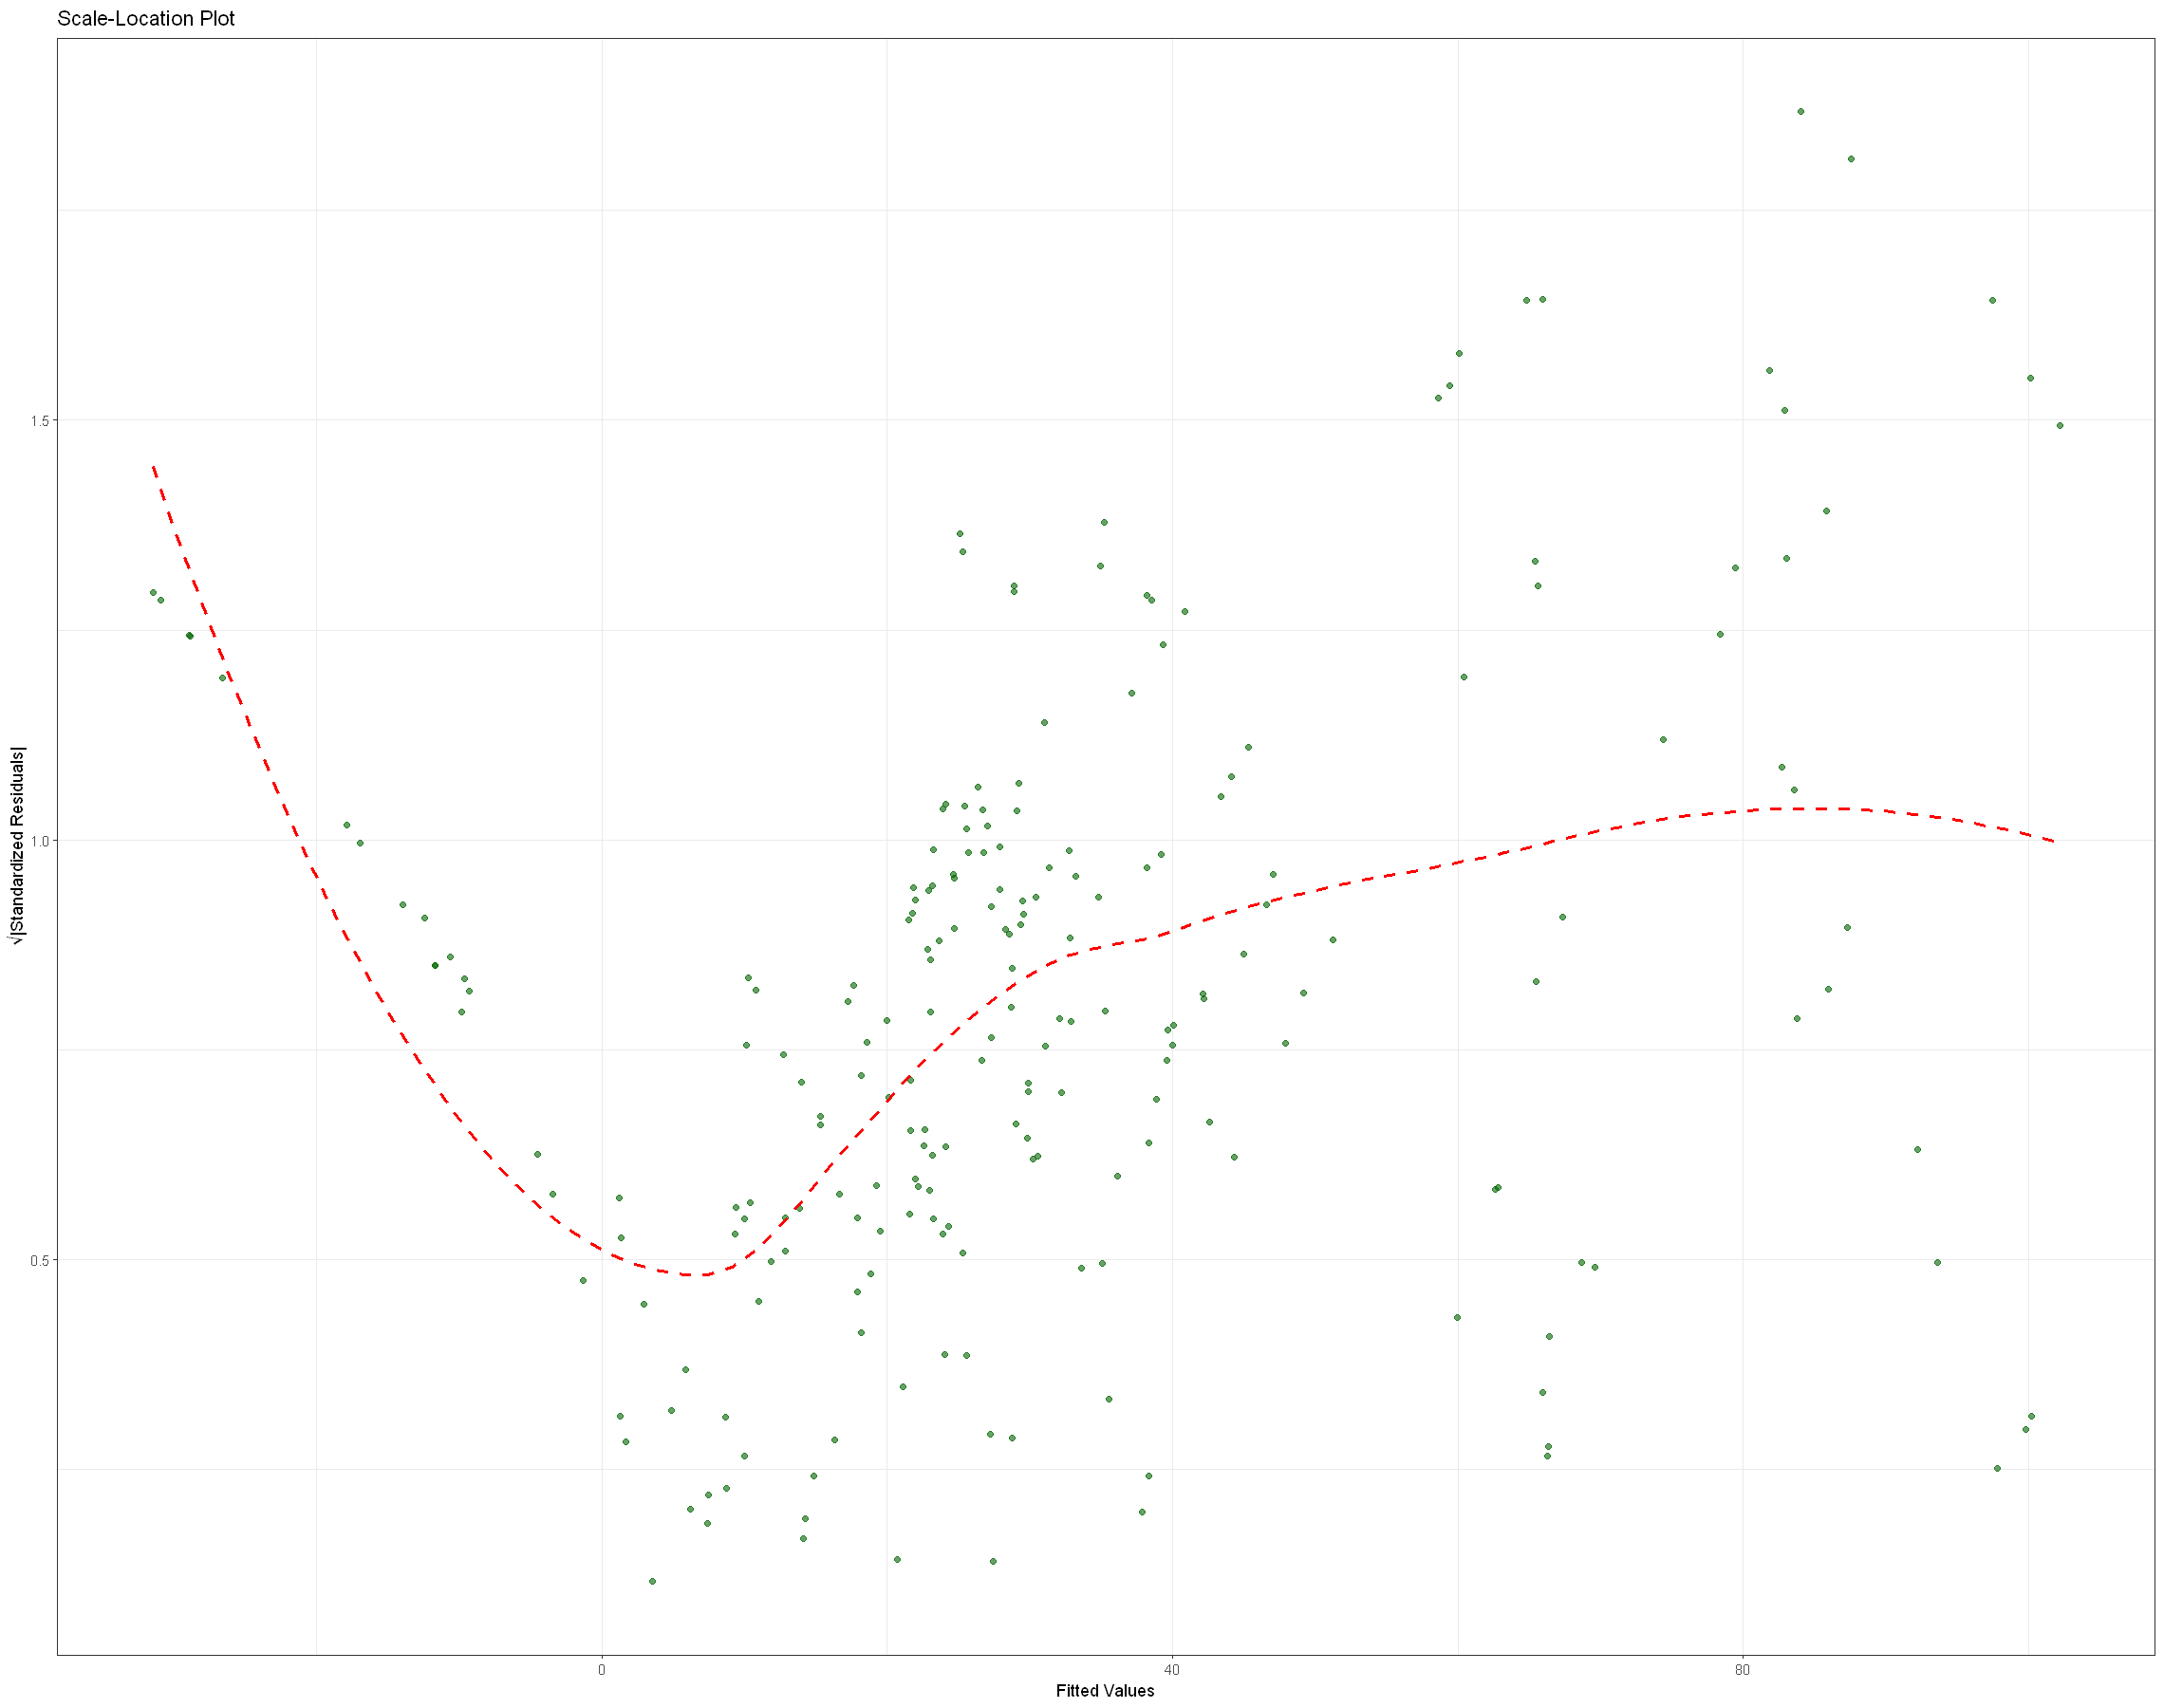

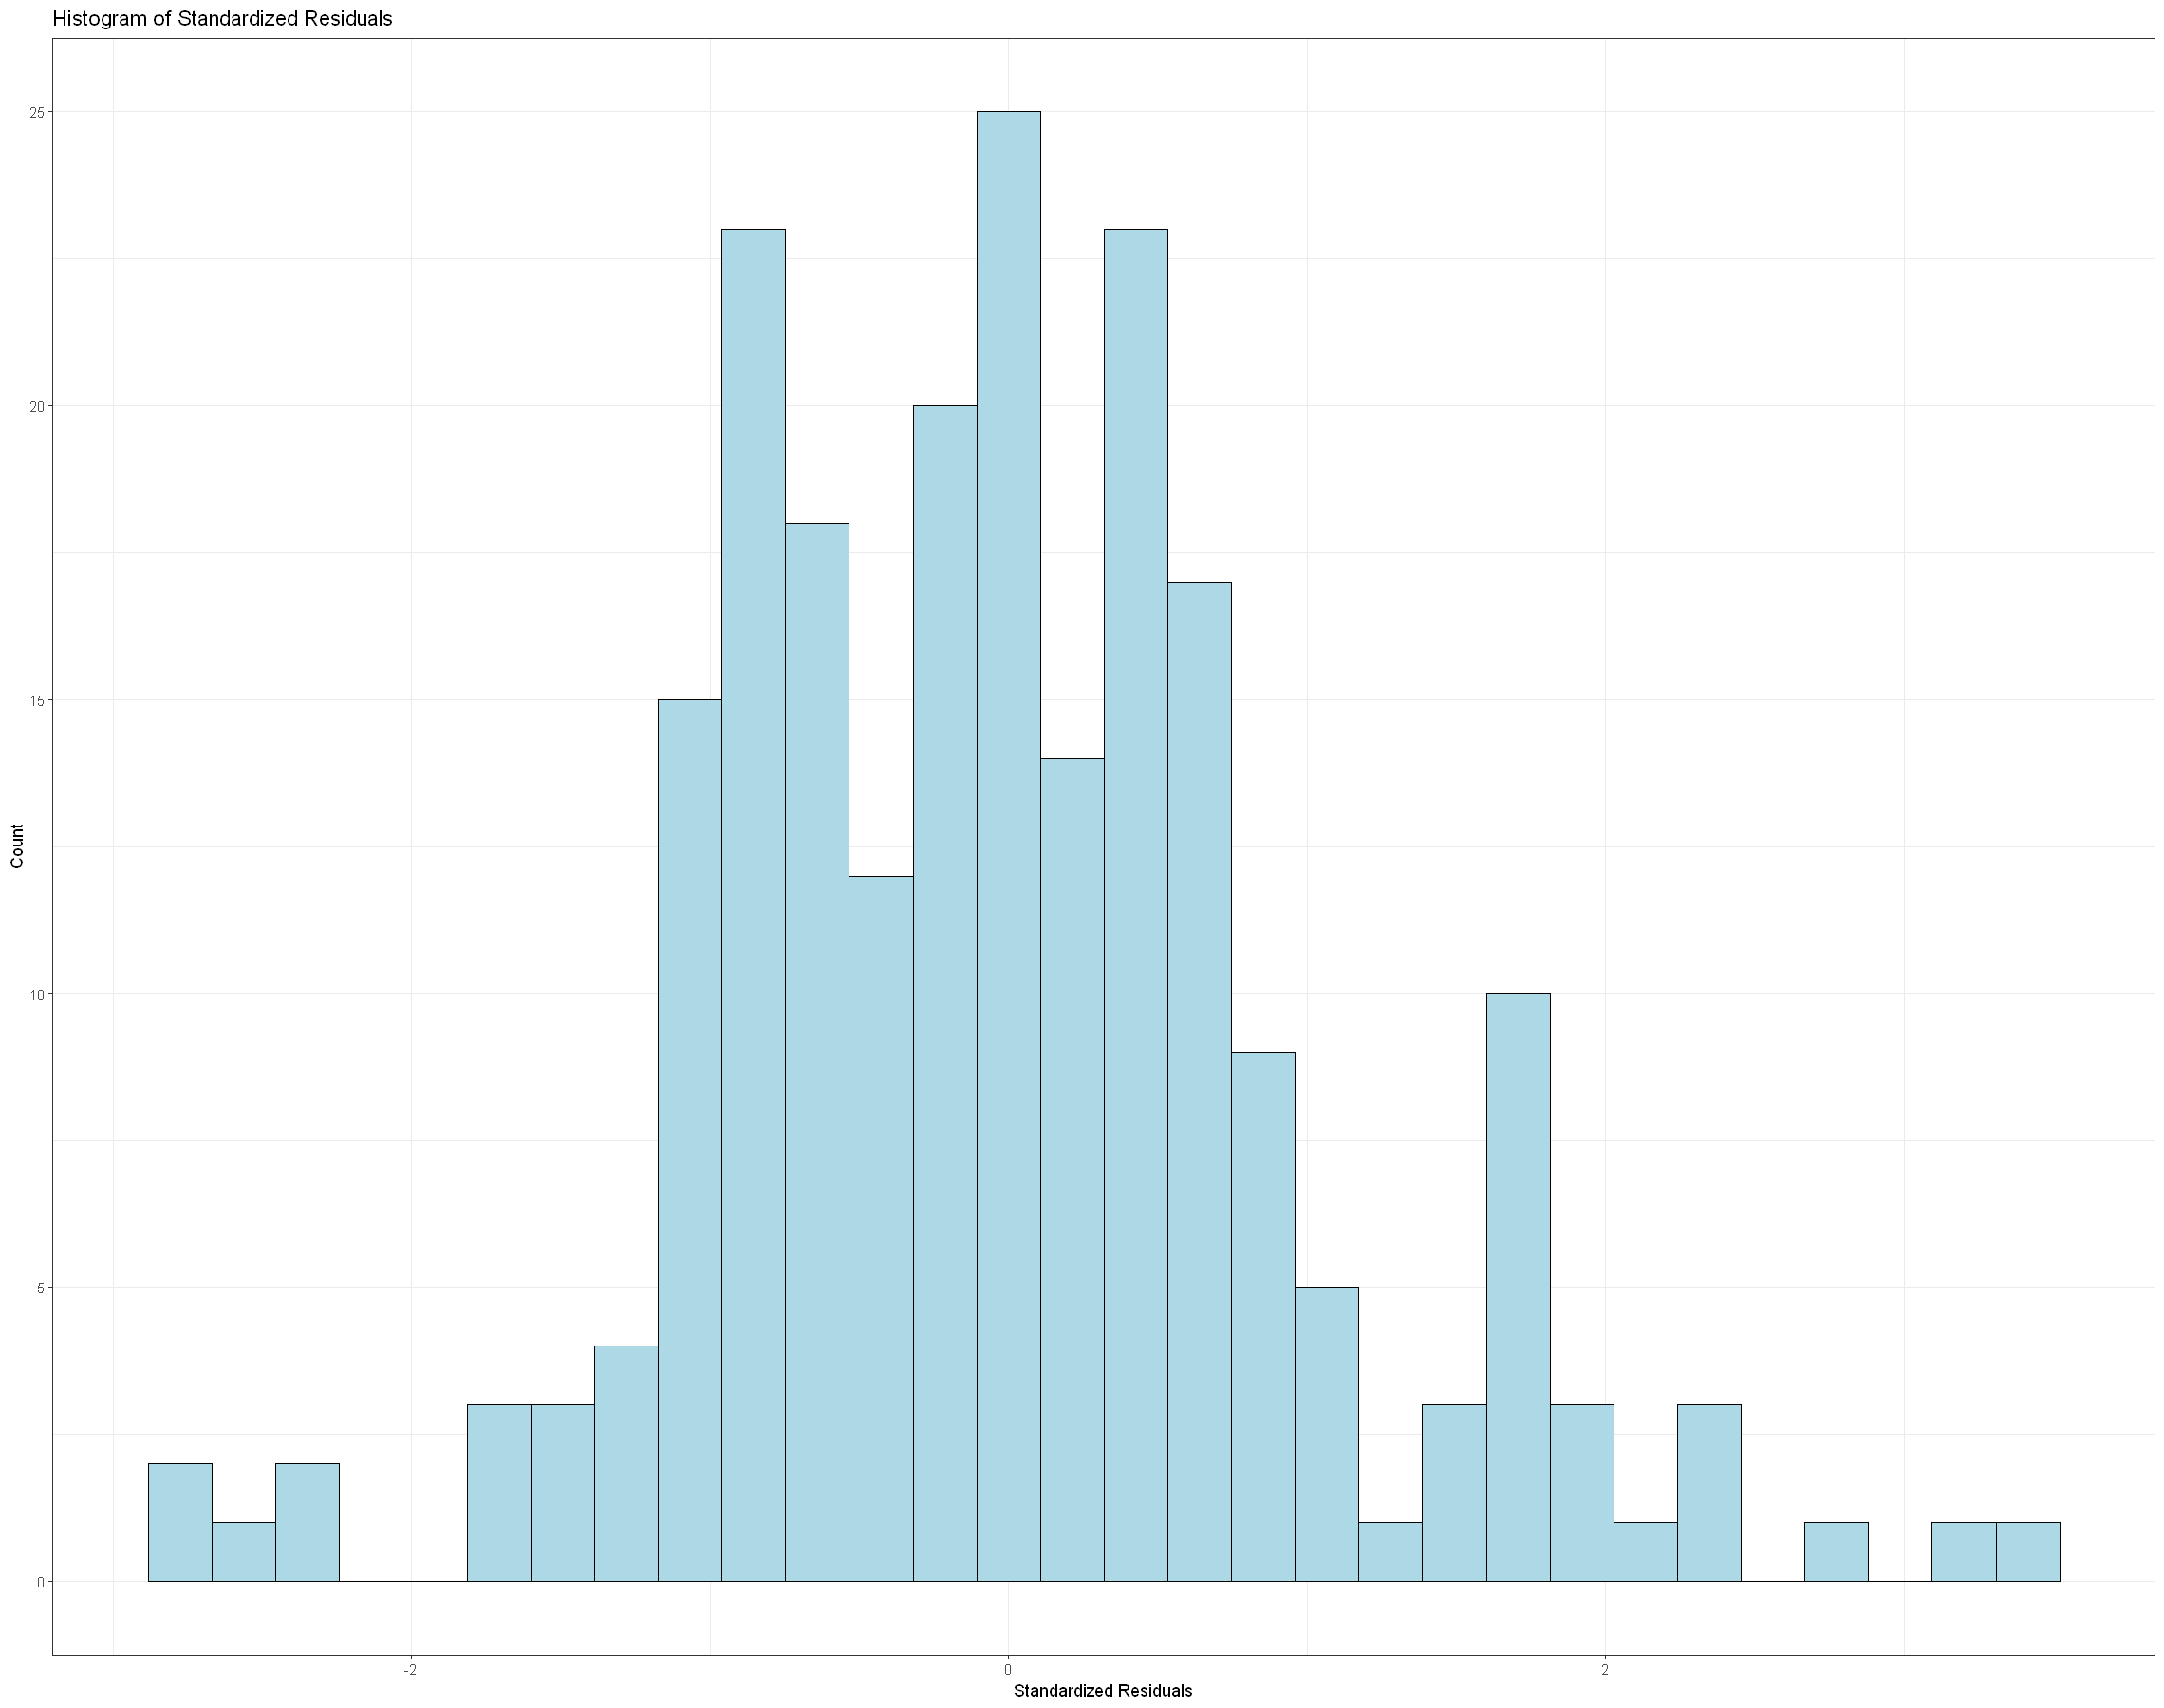

25  24 
 86 114

               hispanic_or_latino        population_18_or_over_male 
                         2.436188                          4.356888 
        employment_total_employed     mean_household_income_dollars 
                         3.909949                          4.037348 
total_population_bachelors_degree                     total_veteran 
                         4.441363                          2.041249 
           total_foreign_born_pop        total_household_w_internet 
                         4.594095                          2.872773 
           average_household_size                   total_borrowers 
                         1.454985                          2.739081 
                   minority_share 
                         2.248205 


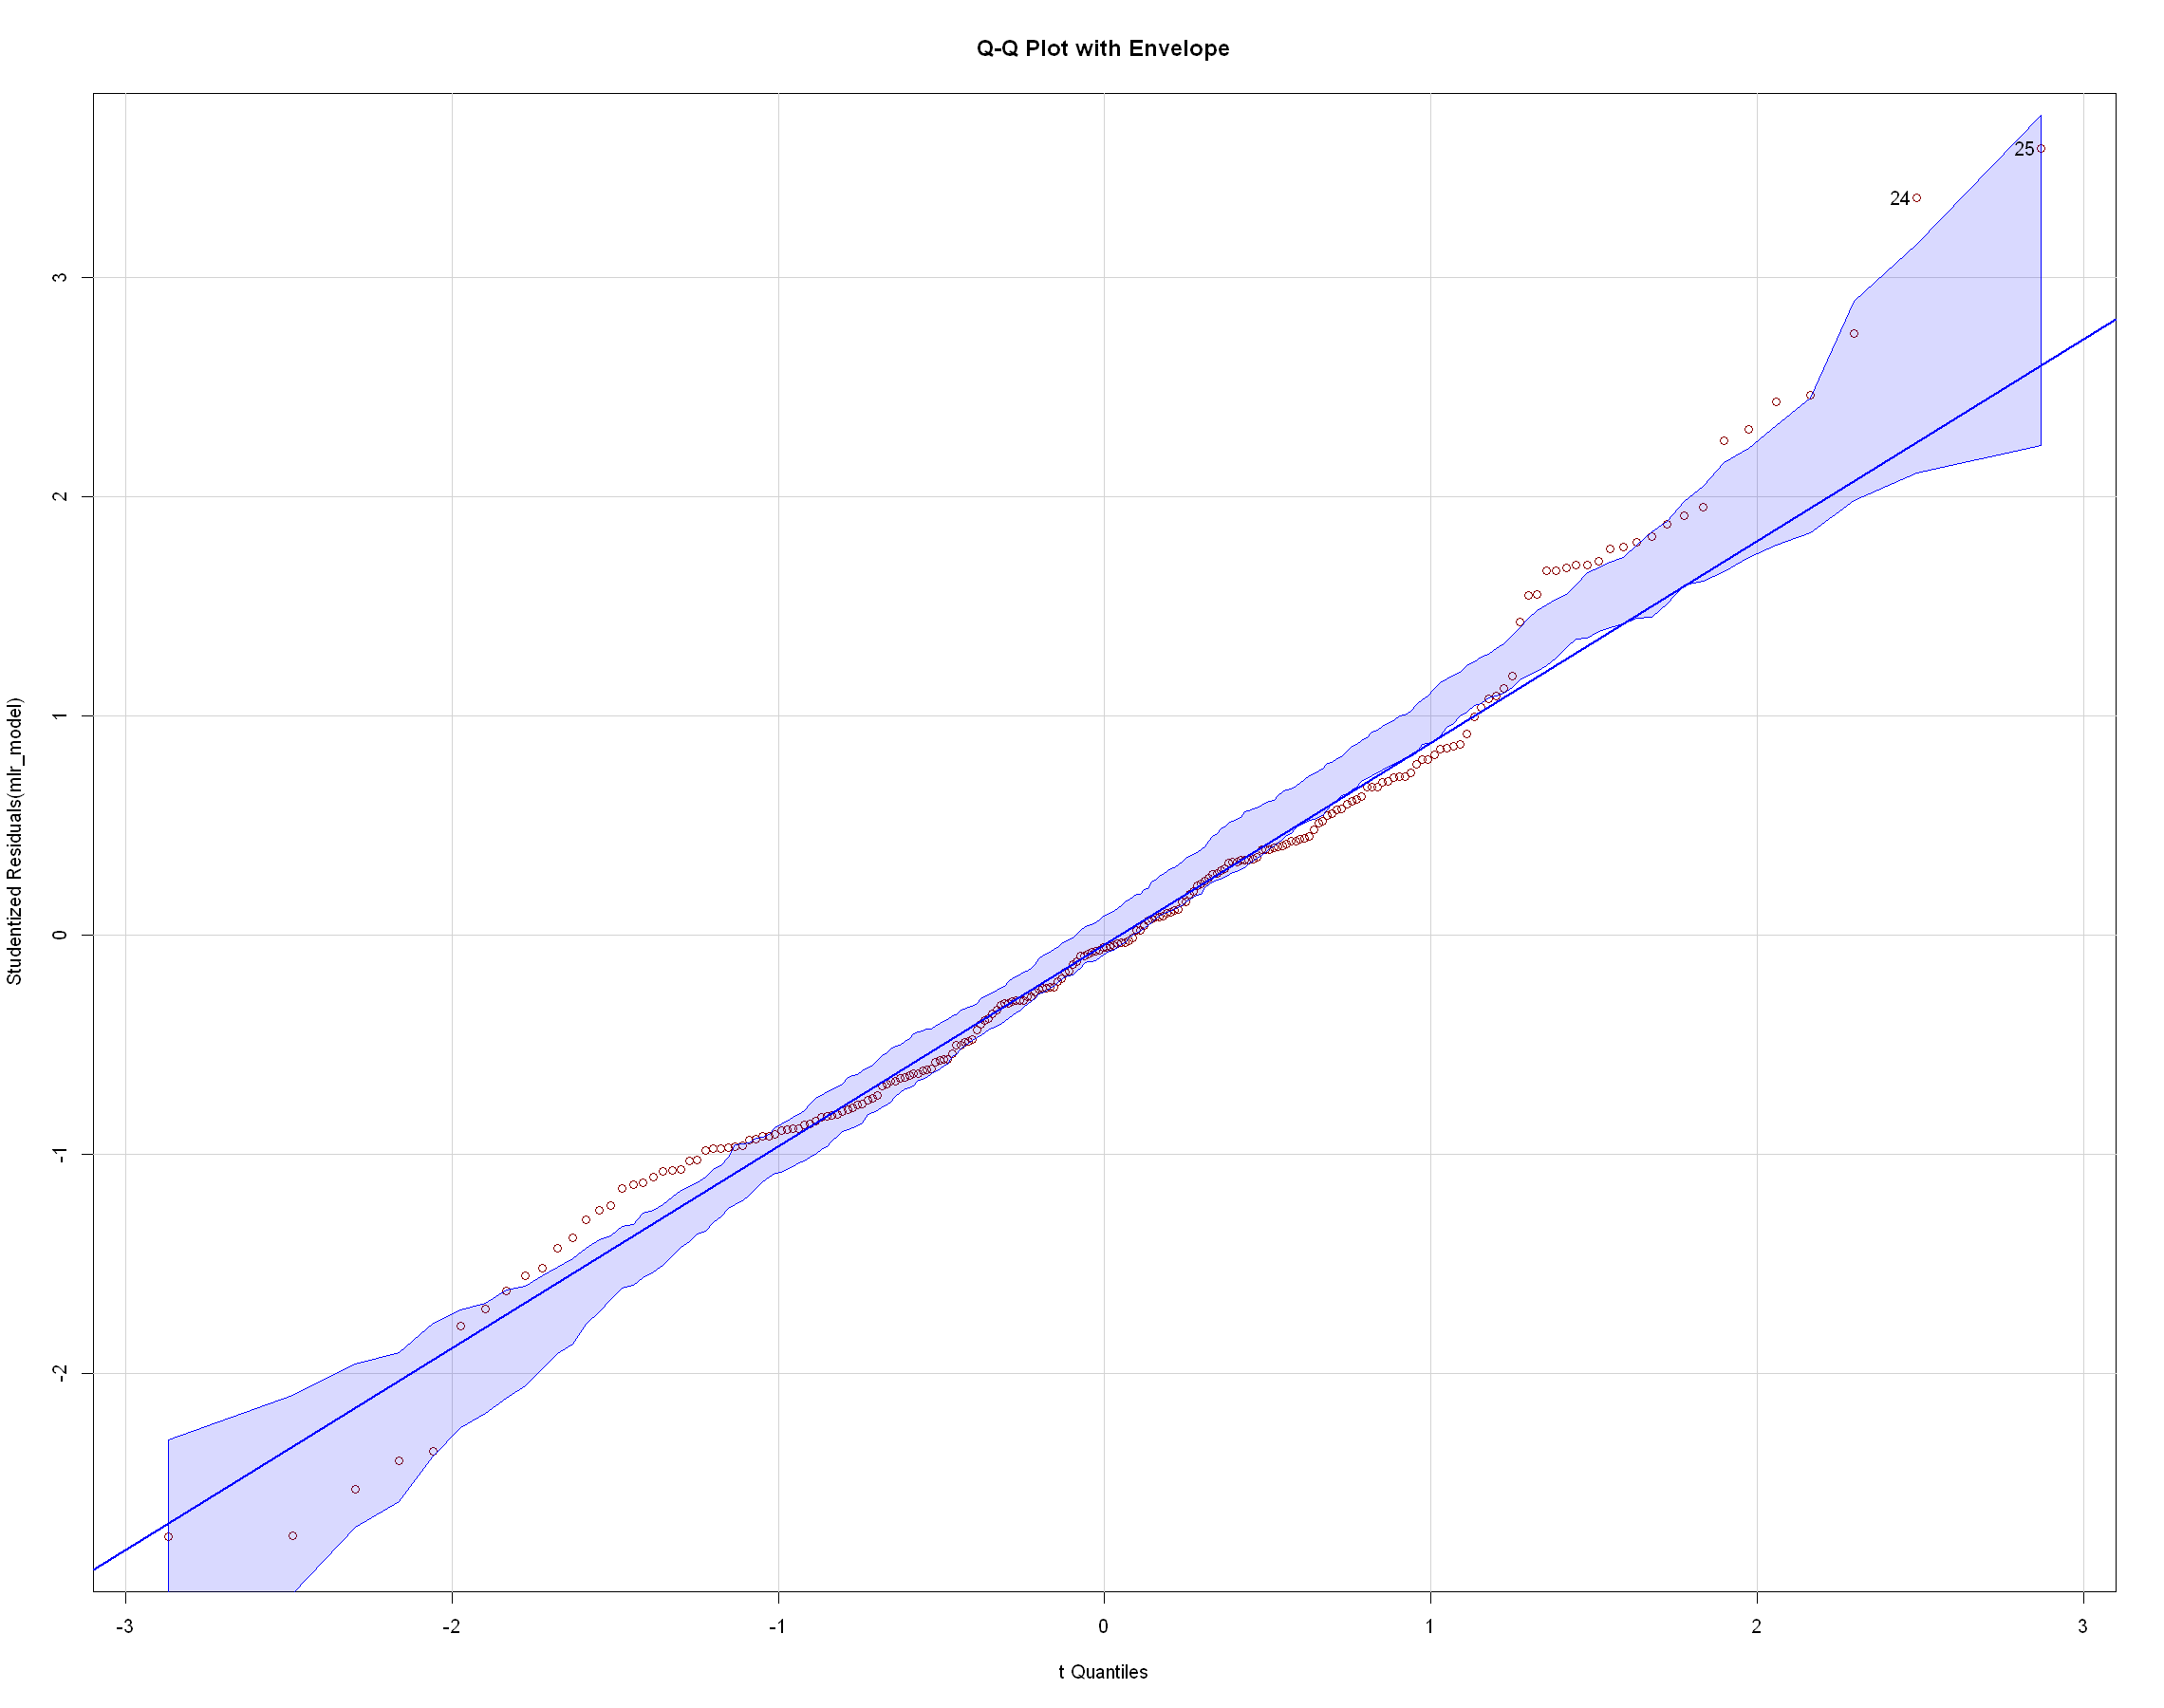

In [189]:
# create assumptions graph here

# Assumption 1: Linearity - mlr_model
# Add standardized residuals
resid_data <- train_data %>%
  mutate(std_resid = rstandard(mlr_model))

# Residuals vs Fitted
fitted_vals <- fitted(mlr_model)
p1 <- ggplot(data.frame(fitted_vals, std_resid = resid_data$std_resid), 
             aes(x = fitted_vals, y = std_resid)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residuals vs Fitted Values",
       x = "Fitted Values", y = "Standardized Residuals") +
  theme_bw()

# Individual predictor plots
predictors <- setdiff(names(train_data), "total_balance_billions")

plots <- map(predictors, function(var) {
  ggplot(resid_data, aes(x = !!sym(var), y = std_resid)) +
    geom_point(alpha = 0.6, color = "darkblue") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(title = paste("Standard Residuals vs", var),
         x = var, y = "Standard Residuals") +
    theme_bw()
})

# Validate ggplot objects
stopifnot(all(map_lgl(plots, ~ inherits(.x, "ggplot"))))

# Combine and wrap
wrap_plots(c(list(p1), plots), ncol = 2)

# Assumption 2: Independence (We see random scatter, and do not see any obvious patterns)
resid_data <- train_data %>%
  mutate(std_resid = rstandard(mlr_model),
         obs_index = row_number())

ggplot(resid_data, aes(x = obs_index, y = std_resid)) +
  geom_point(alpha = 0.6, color = "purple") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Standardized Residuals vs Observation Index",
       x = "Observation Index", y = "Standardized Residuals") +
  theme_bw()

# Assumption 3: Homoscedasticity (The shape of the graph indicates that the model does not satisfy this assumption)
resid_data <- resid_data %>%
  mutate(sqrt_abs_std_resid = sqrt(abs(std_resid)))

# Plot Scale-Location (Spread vs Fitted)
ggplot(data.frame(fitted_vals, sqrt_abs_std_resid = resid_data$sqrt_abs_std_resid),
       aes(x = fitted_vals, y = sqrt_abs_std_resid)) +
  geom_point(alpha = 0.6, color = "darkgreen") +
  geom_smooth(method = "loess", se = FALSE, color = "red", linetype = "dashed") +
  labs(title = "Scale-Location Plot",
       x = "Fitted Values",
       y = "√|Standardized Residuals|") +
  theme_bw()

# Assumption 4: Normality
ggplot(resid_data, aes(x = std_resid)) +
  geom_histogram(color = "black", fill = "lightblue", bins = 30) +
  labs(title = "Histogram of Standardized Residuals",
       x = "Standardized Residuals", y = "Count") +
  theme_bw()

# Normality check using q-q plot
qqPlot(mlr_model, main = "Q-Q Plot with Envelope", col = "darkred")

# Assumption 5: Multicollinearity
vif_values <- vif(mlr_model)
print(vif_values)


### Log-transformed MLR Model without State Cluster

In [190]:
set.seed(123)
mlr_model_transformed <- lm(log(total_balance_billions) ~ .-state_cluster, data = train_data)
summary(mlr_model_transformed)


Call:
lm(formula = log(total_balance_billions) ~ . - state_cluster, 
    data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50590 -0.43261  0.02354  0.40901  1.14826 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.655e+00  3.042e+00   1.530   0.1274    
hispanic_or_latino                -4.288e-01  5.672e-01  -0.756   0.4505    
population_18_or_over_male        -1.586e+01  7.264e+00  -2.184   0.0301 *  
employment_total_employed         -5.795e+00  2.161e+00  -2.682   0.0079 ** 
mean_household_income_dollars     -5.494e-05  4.904e-06 -11.203  < 2e-16 ***
total_population_bachelors_degree  3.271e+00  1.545e+00   2.118   0.0354 *  
total_veteran                     -2.049e+01  3.505e+00  -5.845 1.94e-08 ***
total_foreign_born_pop             9.526e+00  1.326e+00   7.183 1.19e-11 ***
total_household_w_internet         1.173e+01  1.652e+00   7.104 1.89e-11 ***
average_household_

In [191]:
# create assumpitons graph here and compare to see if log transformation actually improved anything

### MLR model with State Cluster

In [192]:
mlr_model_cluster <- lm(total_balance_billions ~ ., data = train_data)
summary(mlr_model_cluster)


Call:
lm(formula = total_balance_billions ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.686 -12.190  -0.661   9.743  55.742 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -4.868e+01  1.253e+02  -0.388 0.698054    
hispanic_or_latino                 5.638e+00  1.955e+01   0.288 0.773370    
population_18_or_over_male        -1.346e+02  2.809e+02  -0.479 0.632456    
employment_total_employed         -9.712e+01  7.749e+01  -1.253 0.211477    
mean_household_income_dollars     -1.013e-03  1.773e-04  -5.713 3.84e-08 ***
total_population_bachelors_degree -3.744e+01  5.746e+01  -0.652 0.515428    
total_veteran                     -6.203e+02  1.274e+02  -4.870 2.22e-06 ***
total_foreign_born_pop             5.241e+02  5.533e+01   9.473  < 2e-16 ***
total_household_w_internet         2.219e+02  5.684e+01   3.904 0.000128 ***
average_household_size             2.582e+01  1.197e+0

In [193]:
# create asusmptions graph here and compare if it is any different with the clusters

### Log-transformed MLR Model with State Cluster

In [194]:
mlr_model_transformed_cluster <- lm(log(total_balance_billions) ~ ., data = train_data)
summary(mlr_model_transformed_cluster)


Call:
lm(formula = log(total_balance_billions) ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.05737 -0.37635  0.01666  0.33033  1.22936 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        3.006e+00  3.166e+00   0.950  0.34347    
hispanic_or_latino                -4.633e-01  4.941e-01  -0.938  0.34952    
population_18_or_over_male        -1.922e+01  7.099e+00  -2.708  0.00734 ** 
employment_total_employed         -1.373e+00  1.958e+00  -0.701  0.48399    
mean_household_income_dollars     -4.608e-05  4.481e-06 -10.285  < 2e-16 ***
total_population_bachelors_degree  2.180e+00  1.452e+00   1.501  0.13478    
total_veteran                     -1.902e+01  3.218e+00  -5.910 1.40e-08 ***
total_foreign_born_pop             1.609e+01  1.398e+00  11.508  < 2e-16 ***
total_household_w_internet         1.137e+01  1.436e+00   7.916 1.50e-13 ***
average_household_size             4.88

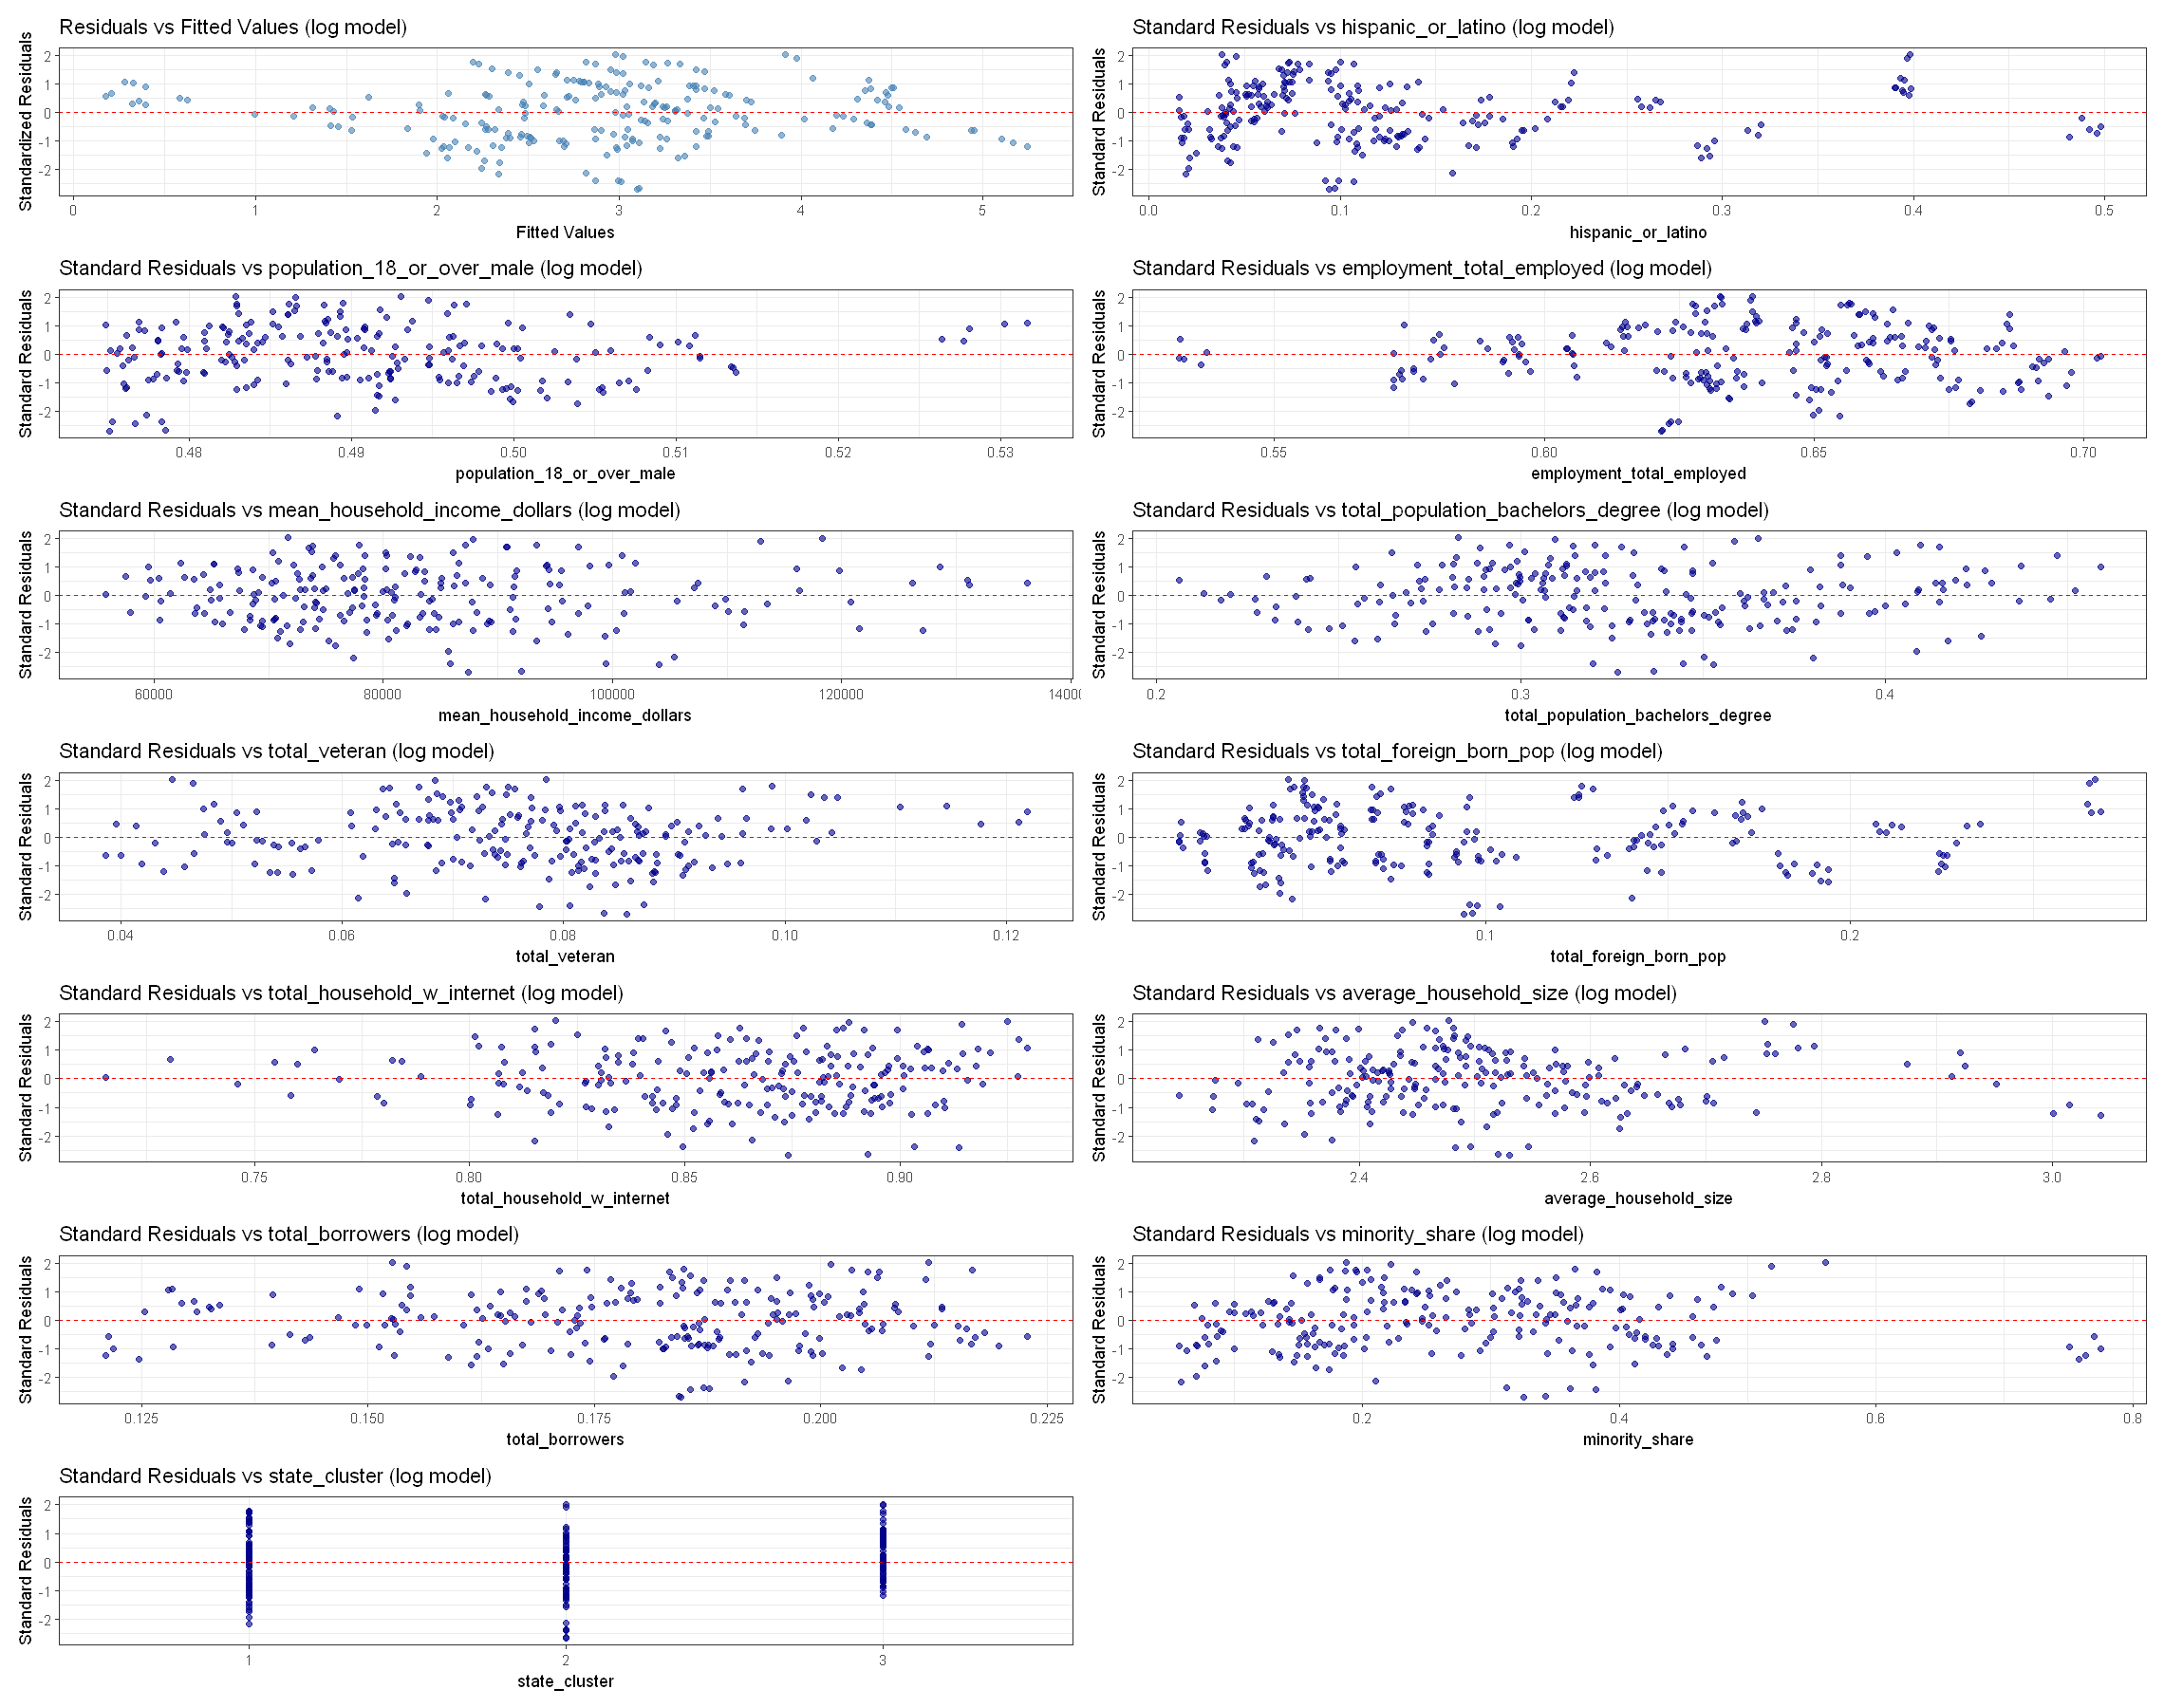

`geom_smooth()` using formula = 'y ~ x'


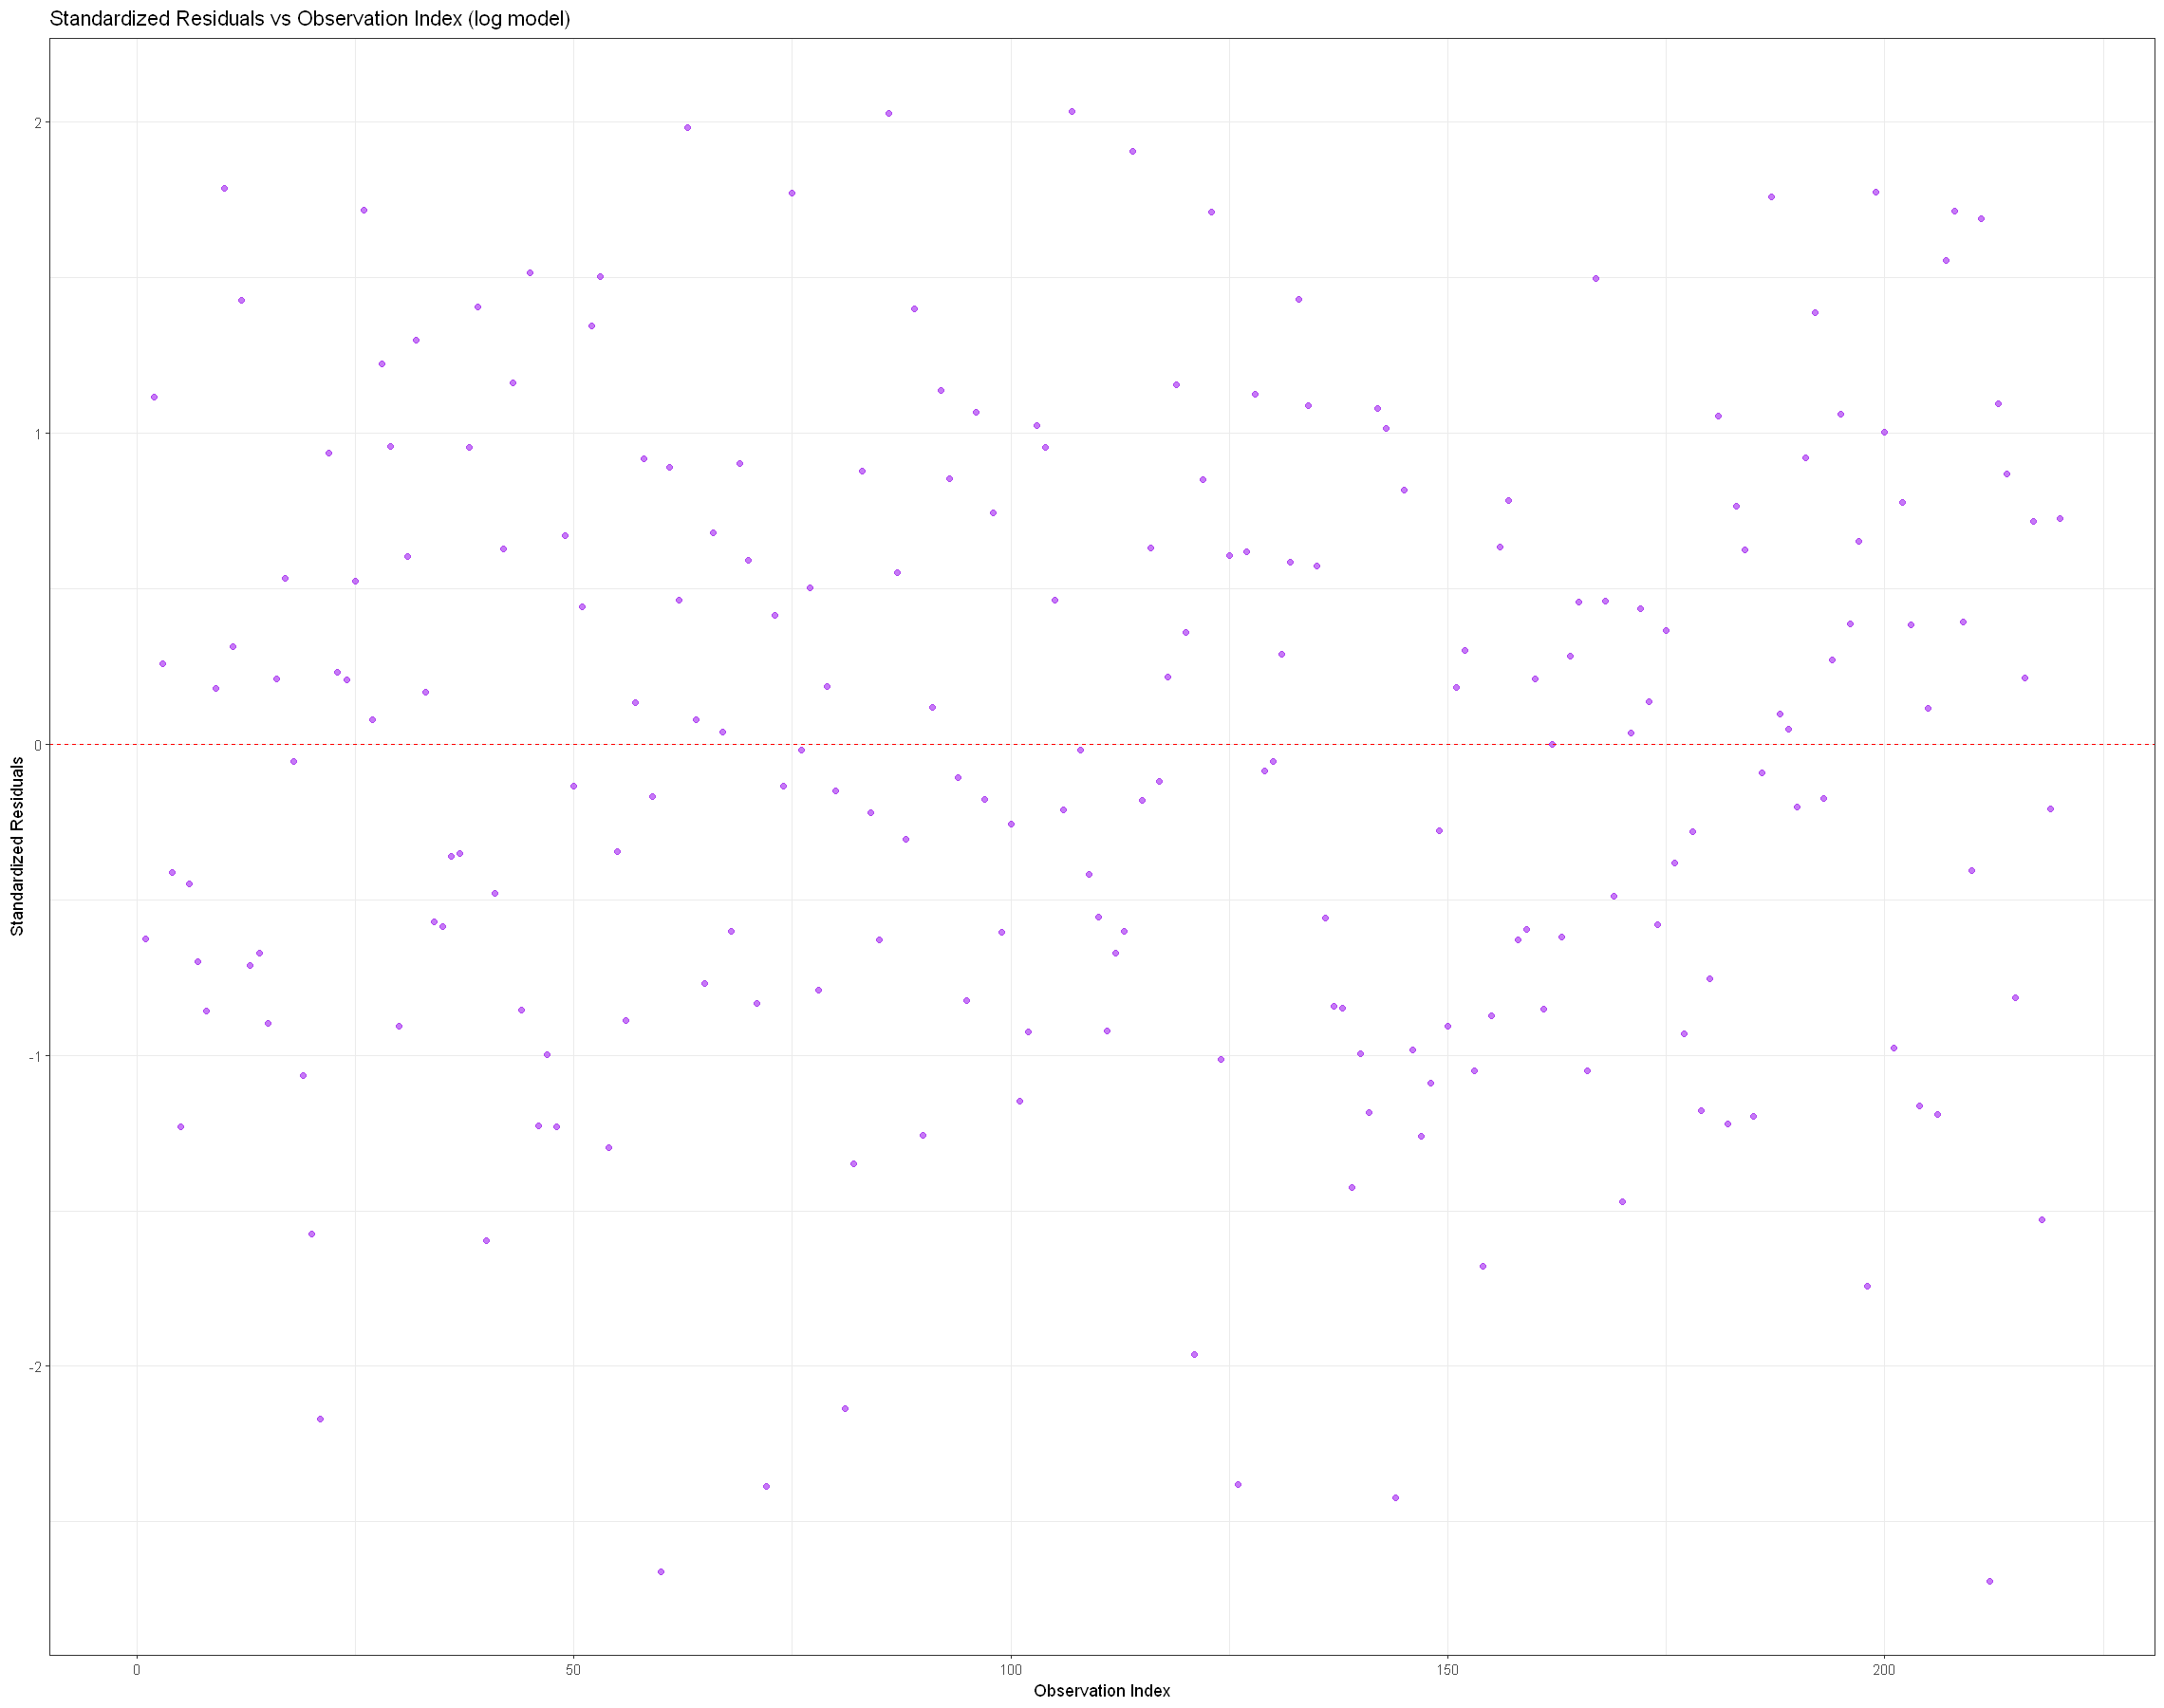

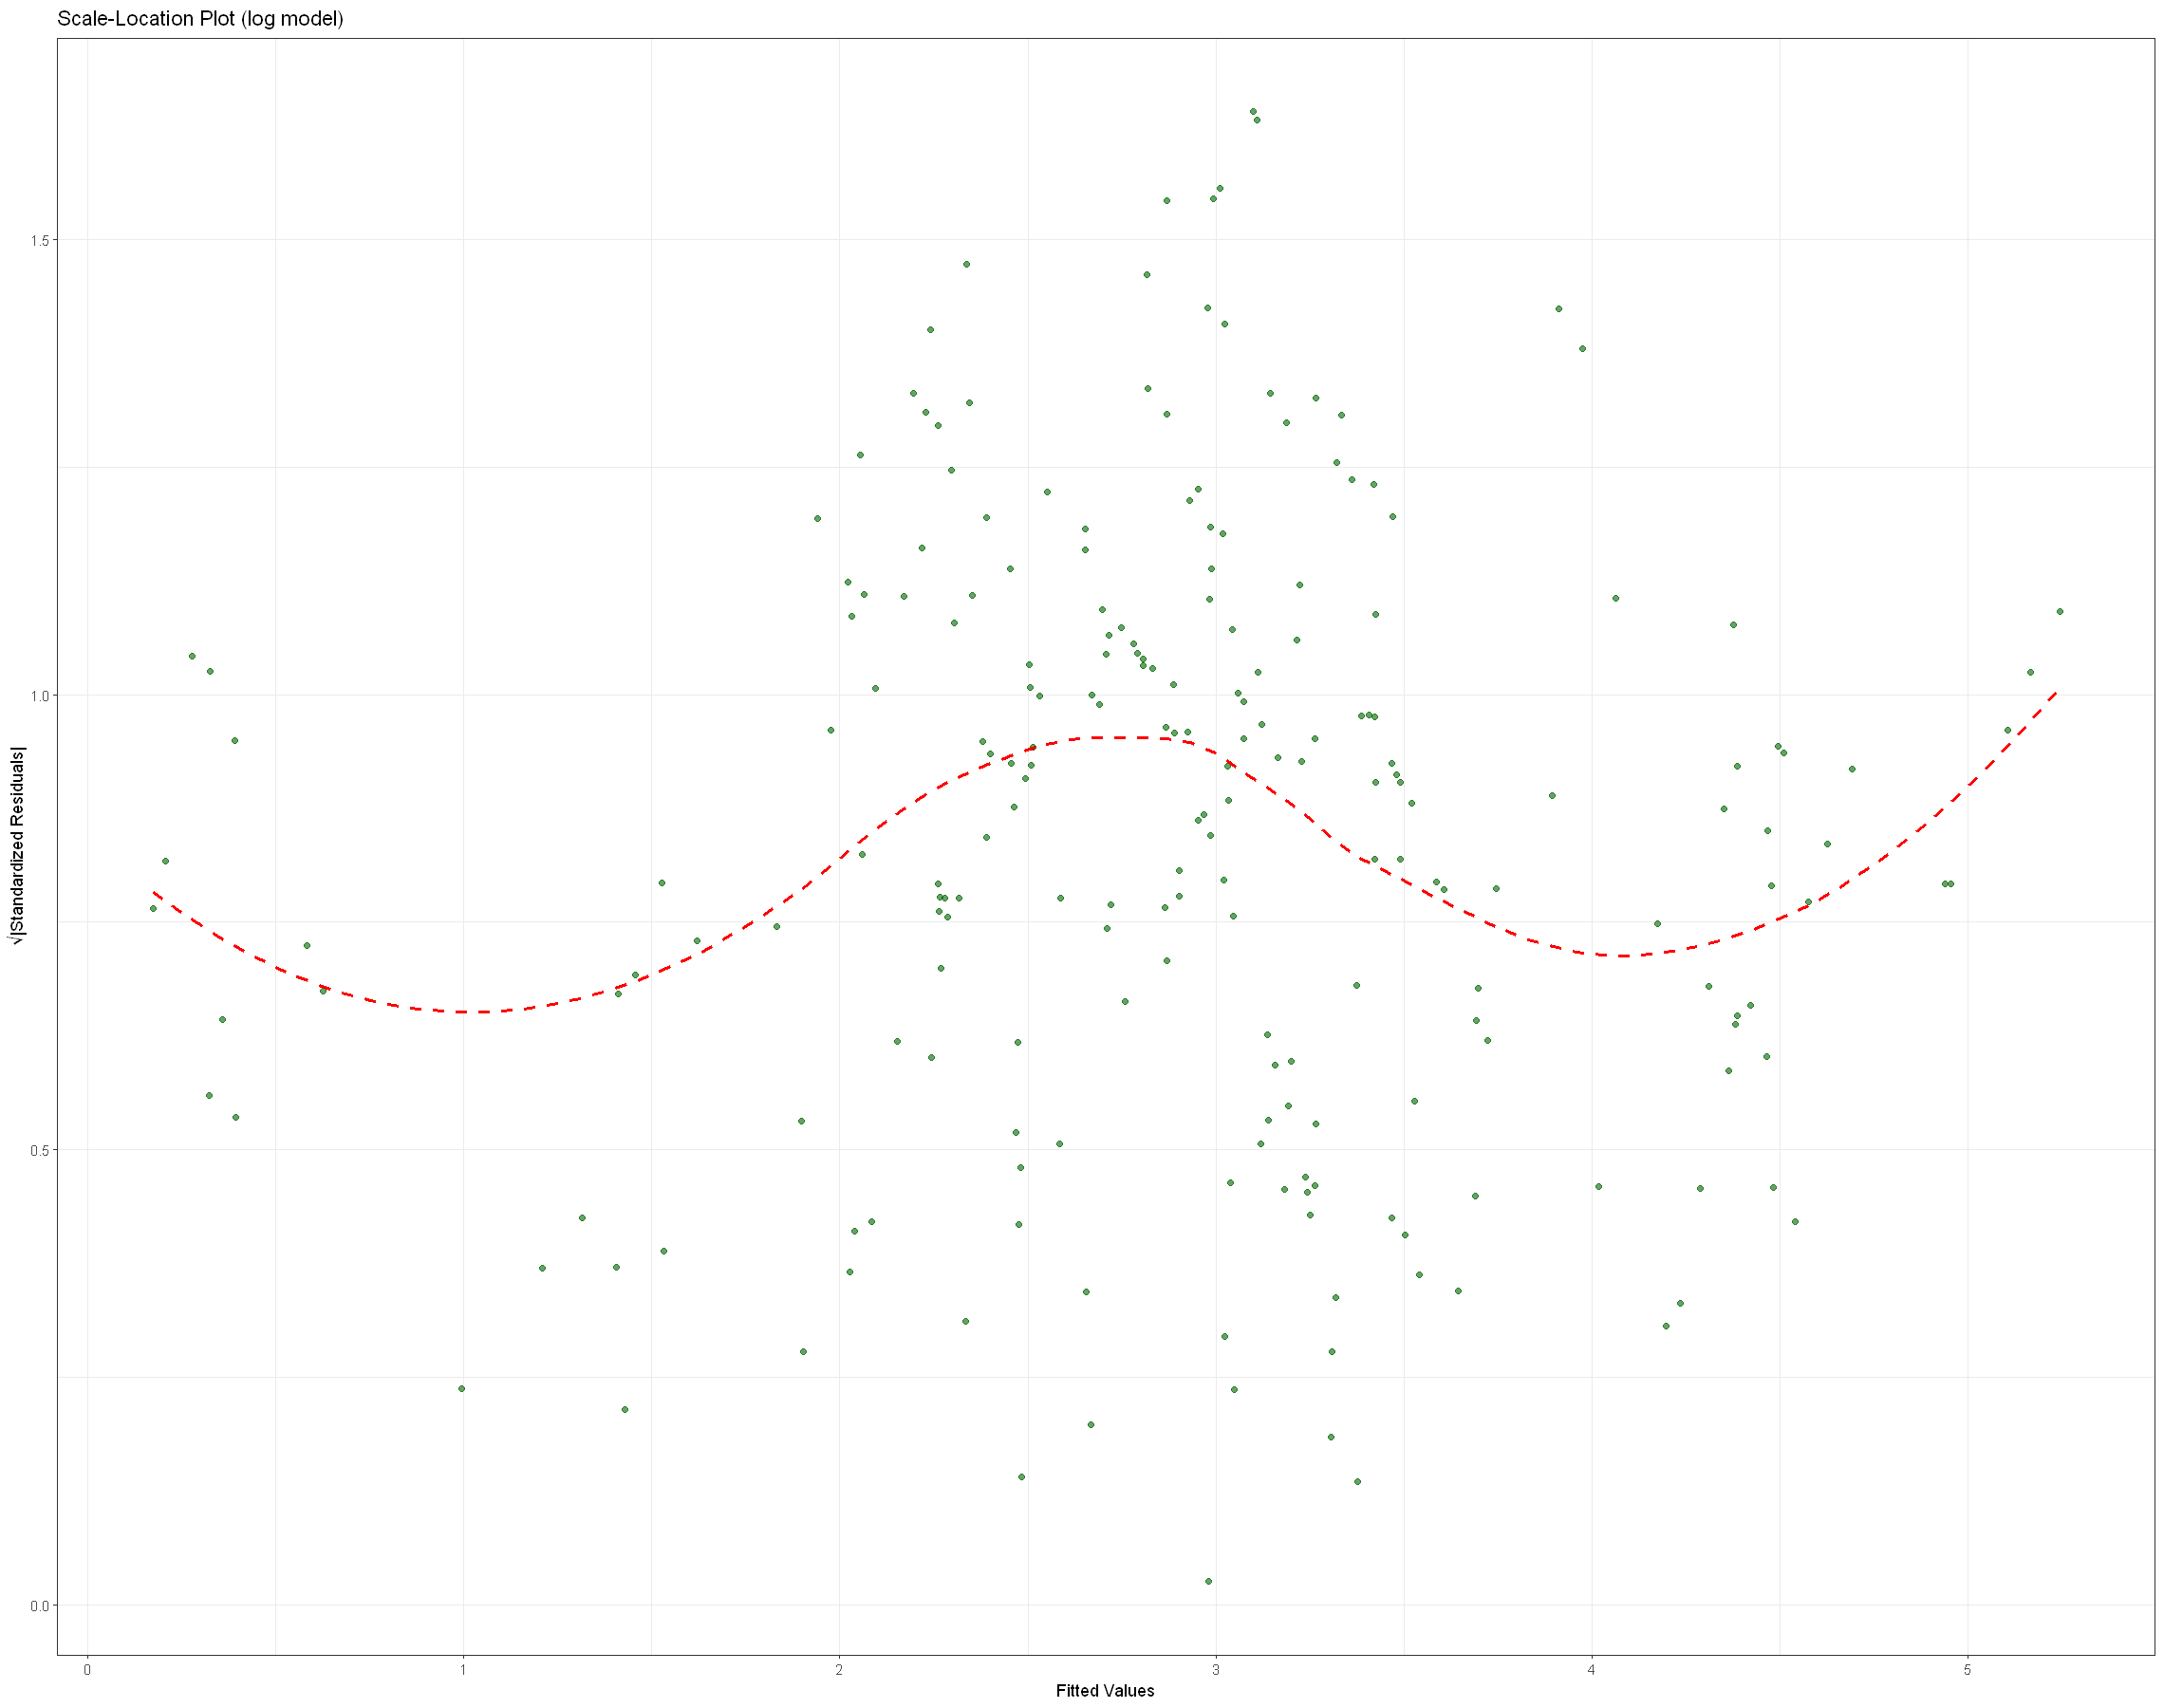

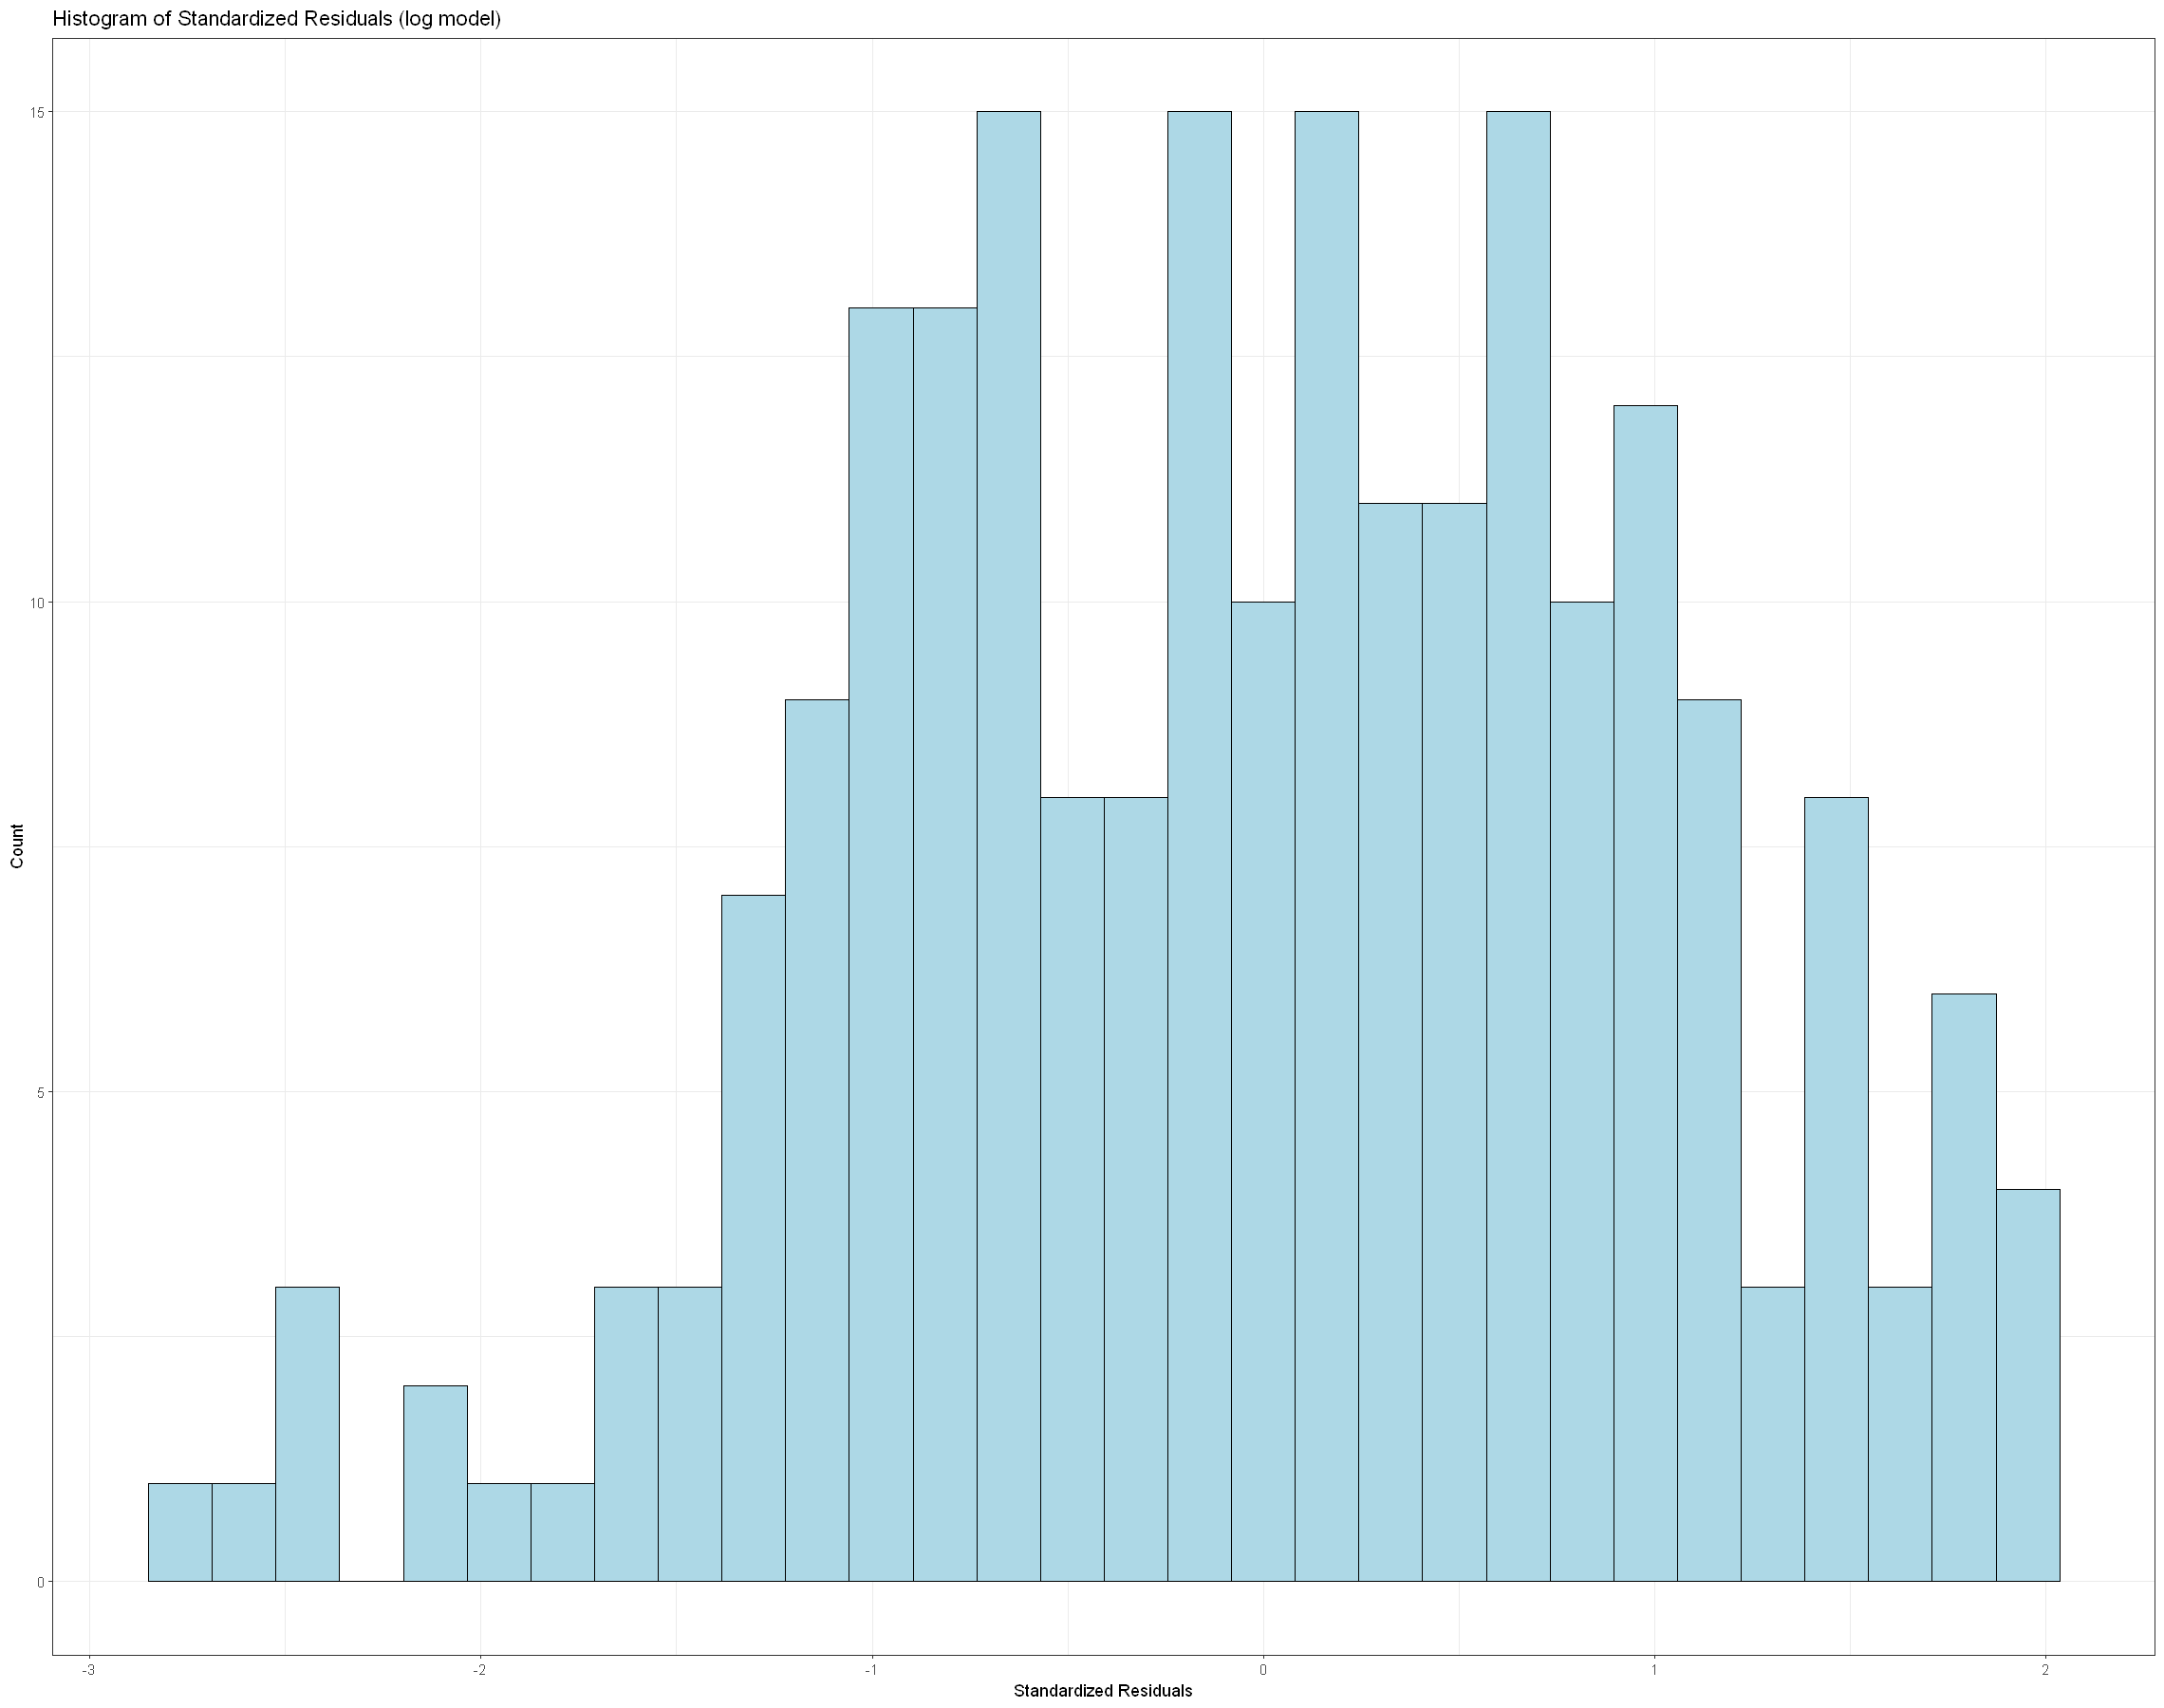

38  37 
 60 212

               hispanic_or_latino        population_18_or_over_male 
                         2.436188                          4.356888 
        employment_total_employed     mean_household_income_dollars 
                         3.909949                          4.037348 
total_population_bachelors_degree                     total_veteran 
                         4.441363                          2.041249 
           total_foreign_born_pop        total_household_w_internet 
                         4.594095                          2.872773 
           average_household_size                   total_borrowers 
                         1.454985                          2.739081 
                   minority_share 
                         2.248205 


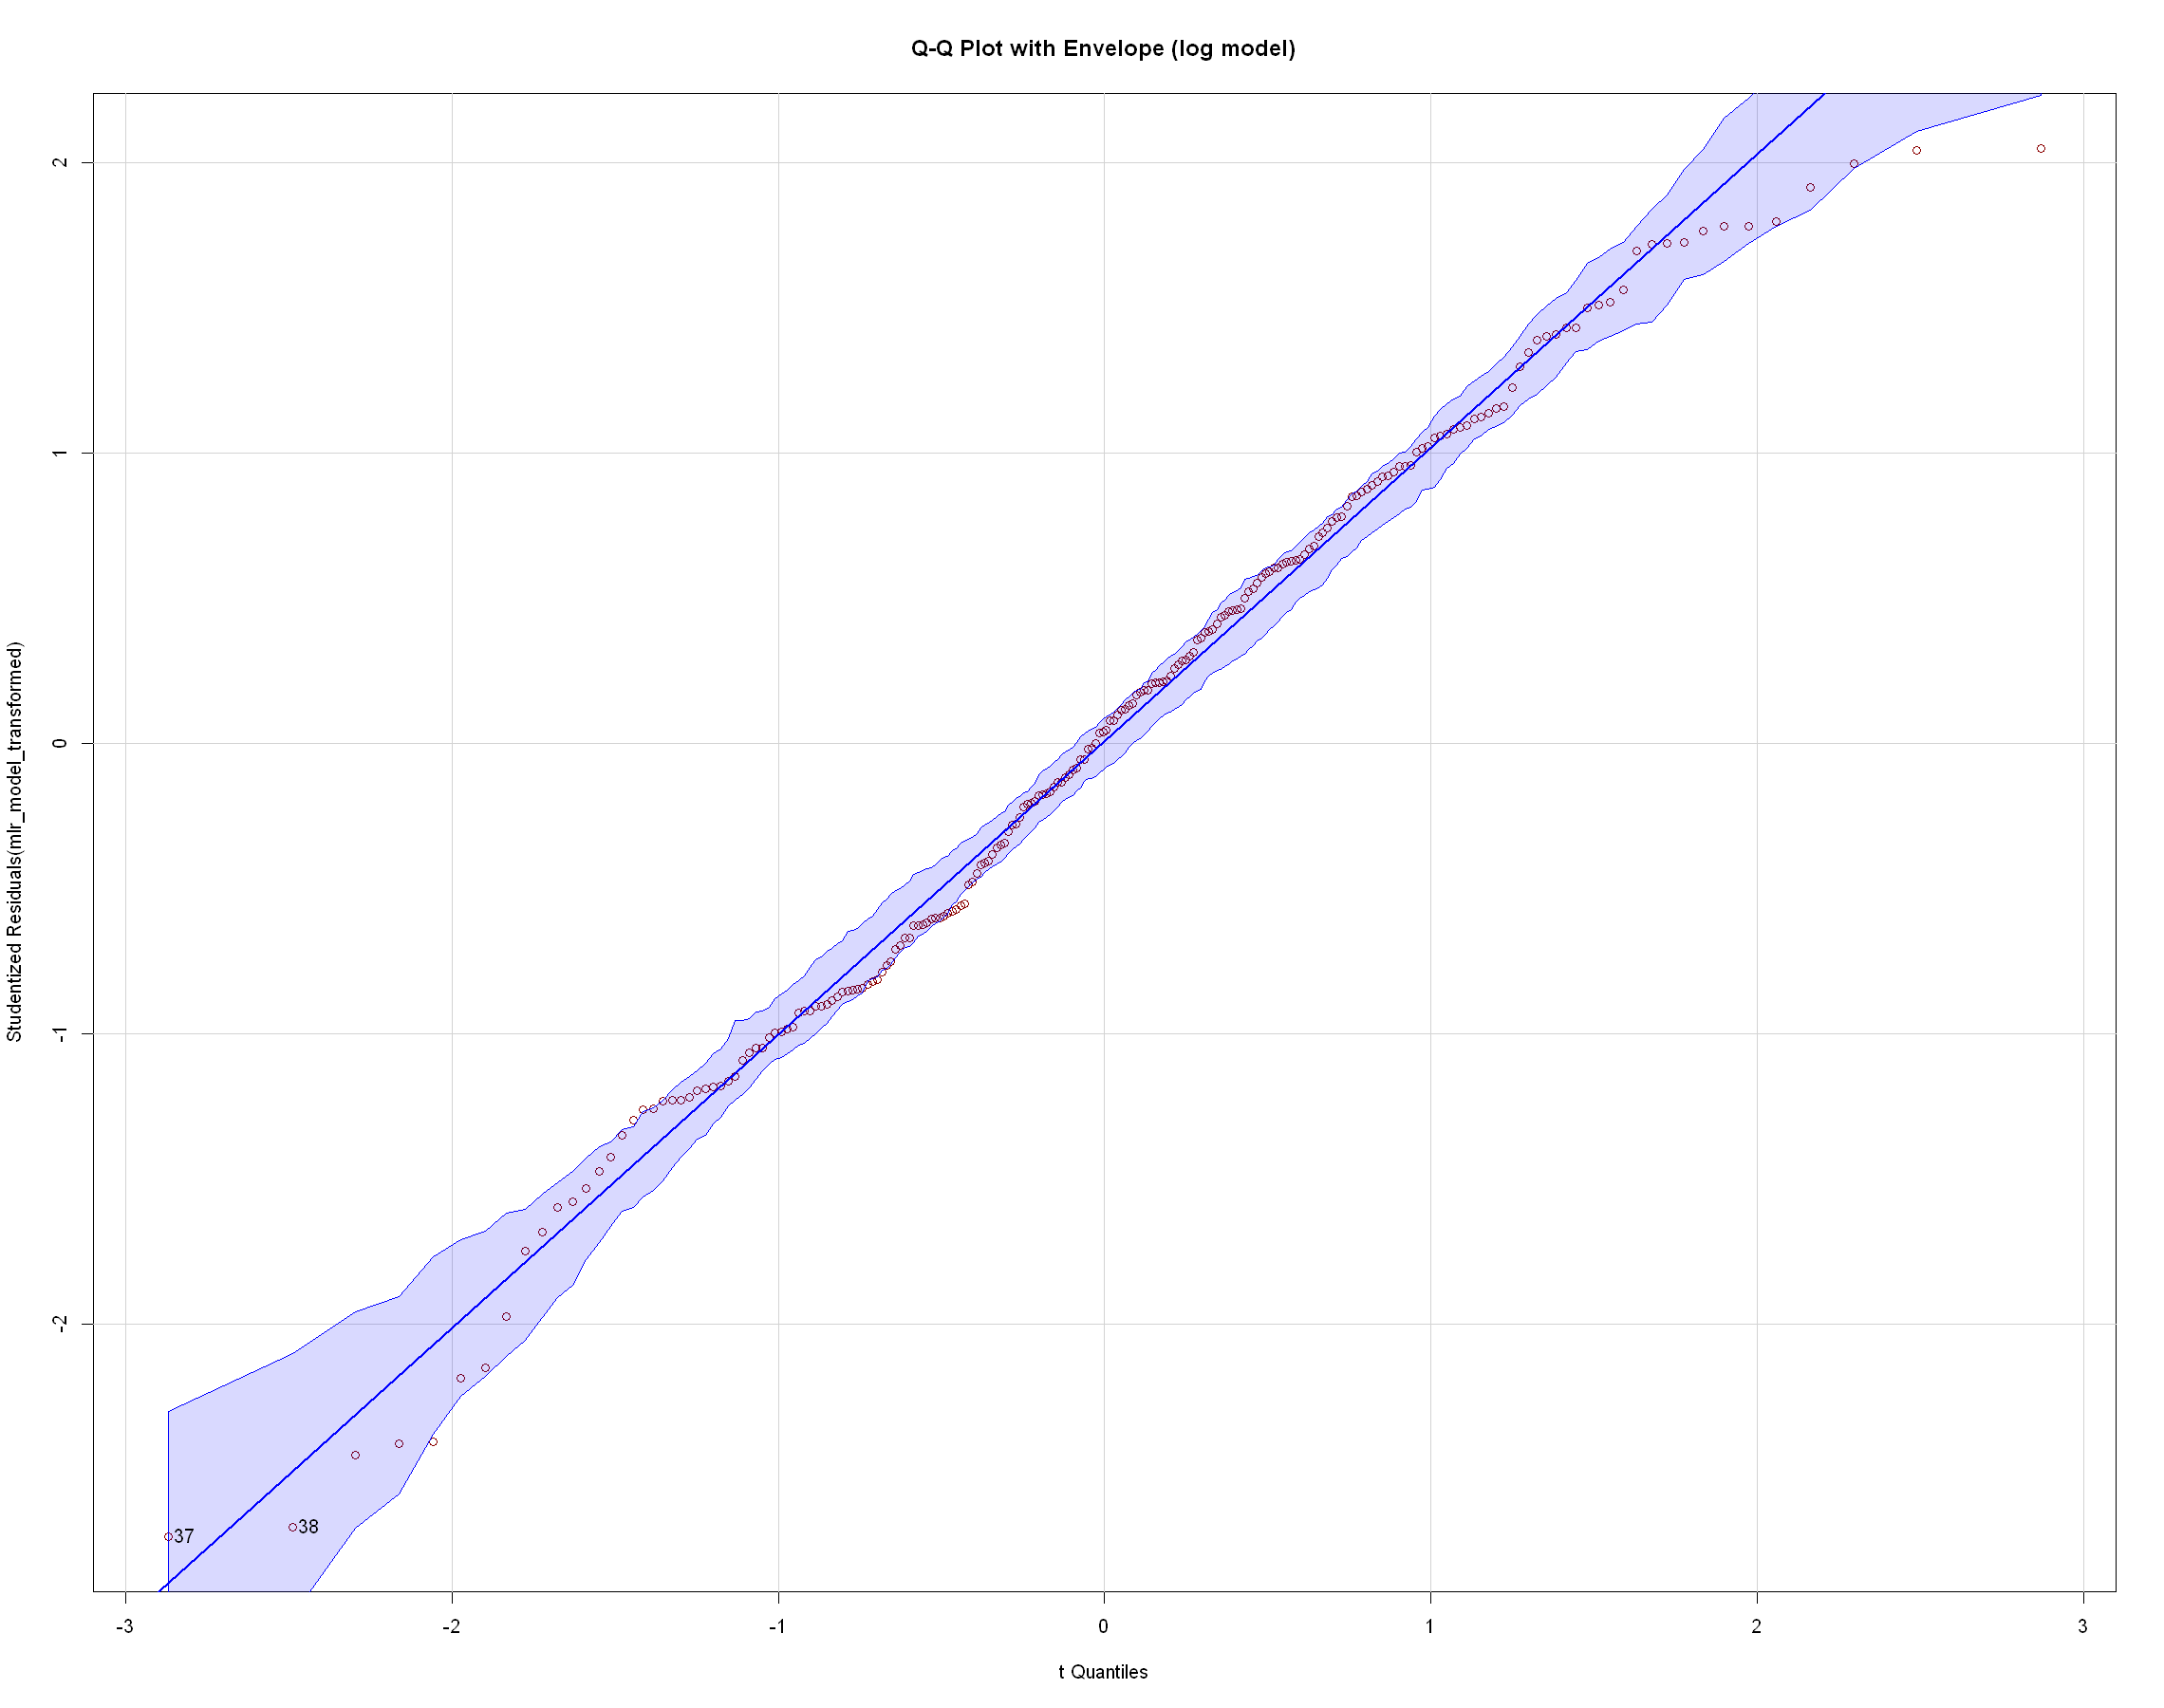

In [195]:
# create assumptions graph here and see if the data is any different from original clustered model and compare
# Assumption 1: Linearity
resid_data_log <- train_data %>%
  mutate(std_resid = rstandard(mlr_model_transformed))

fitted_vals_log <- fitted(mlr_model_transformed)
p1_log <- ggplot(data.frame(fitted_vals_log, std_resid = resid_data_log$std_resid), 
                 aes(x = fitted_vals_log, y = std_resid)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residuals vs Fitted Values (log model)",
       x = "Fitted Values", y = "Standardized Residuals") +
  theme_bw()

# Individual predictor plots
predictors <- setdiff(names(train_data), "total_balance_billions")

plots_log <- map(predictors, function(var) {
  ggplot(resid_data_log, aes(x = !!sym(var), y = std_resid)) +
    geom_point(alpha = 0.6, color = "darkblue") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(title = paste("Standard Residuals vs", var, "(log model)"),
         x = var, y = "Standard Residuals") +
    theme_bw()
})

wrap_plots(c(list(p1_log), plots_log), ncol = 2)


# Assumption 2: Independence
resid_data_log <- resid_data_log %>%
  mutate(obs_index = row_number())

ggplot(resid_data_log, aes(x = obs_index, y = std_resid)) +
  geom_point(alpha = 0.6, color = "purple") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Standardized Residuals vs Observation Index (log model)",
       x = "Observation Index", y = "Standardized Residuals") +
  theme_bw()


# Assumption 3: Homoscedasticity
resid_data_log <- resid_data_log %>%
  mutate(sqrt_abs_std_resid = sqrt(abs(std_resid)))

ggplot(data.frame(fitted_vals_log, sqrt_abs_std_resid = resid_data_log$sqrt_abs_std_resid),
       aes(x = fitted_vals_log, y = sqrt_abs_std_resid)) +
  geom_point(alpha = 0.6, color = "darkgreen") +
  geom_smooth(method = "loess", se = FALSE, color = "red", linetype = "dashed") +
  labs(title = "Scale-Location Plot (log model)",
       x = "Fitted Values",
       y = "√|Standardized Residuals|") +
  theme_bw()


# Assumption 4: Normality
ggplot(resid_data_log, aes(x = std_resid)) +
  geom_histogram(color = "black", fill = "lightblue", bins = 30) +
  labs(title = "Histogram of Standardized Residuals (log model)",
       x = "Standardized Residuals", y = "Count") +
  theme_bw()

# Q-Q Plot with envelope
qqPlot(mlr_model_transformed, main = "Q-Q Plot with Envelope (log model)", col = "darkred")


# Assumption 5: Multicollinearity
vif_values_log <- vif(mlr_model_transformed)
print(vif_values_log)


## Predictions

In [196]:
set.seed(123)

rse_squared_mlr_log_model <- (summary(mlr_model_transformed)$sigma)^2
rse_squared_mlr_log_cluster_model <- (summary(mlr_model_transformed_cluster)$sigma)^2

predict_mlr_model <- predict(mlr_model, newdata = test_data, type='response')
predict_mlr_transformed_model <- predict(mlr_model_transformed, newdata = test_data, type='response')
predict_mlr_cluster_model <- predict(mlr_model_cluster, newdata = test_data, type='response')
predict_mlr_cluster_transformed_model <- predict(mlr_model_transformed_cluster, newdata = test_data, type='response')

prediction_dataset <- cbind(State = test_data$state, Actual = test_data$total_balance_billions, 
                            MLR_Model = round(predict_mlr_model,2), 
                            MLR_Model_Log = round(exp(predict_mlr_transformed_model + rse_squared_mlr_log_model/2),2), 
                            MLR_Cluster_Model = round(predict_mlr_cluster_model,2), 
                            MLR_Cluster_Model_Log = round(exp(predict_mlr_cluster_transformed_model + rse_squared_mlr_log_cluster_model/2),2))

prediction_dataset

,State,Actual,MLR_Model,MLR_Model_Log,MLR_Cluster_Model,MLR_Cluster_Model_Log
2,Alabama,22.29,14.88,19.59,15.64,17.77
3,Alabama,23.07,17.99,21.25,19.34,19.76
12,Arizona,30.91,64.92,54.96,48.44,26.66
15,Arizona,31.87,57.03,45.89,39.3,21.17
18,Arkansas,12.12,24.53,18.26,26.47,19.51
19,Arkansas,12.33,26.97,20.5,28.79,21.89
28,Colorado,30.16,36.24,27.29,35.73,29.65
31,Connecticut,18.87,36.09,24.33,30.56,19.91
47,Georgia,65.98,62.96,118.15,69.71,164.2
57,Idaho,7.36,28.63,17.83,30.51,15.01
